# **Intrusion detection system**

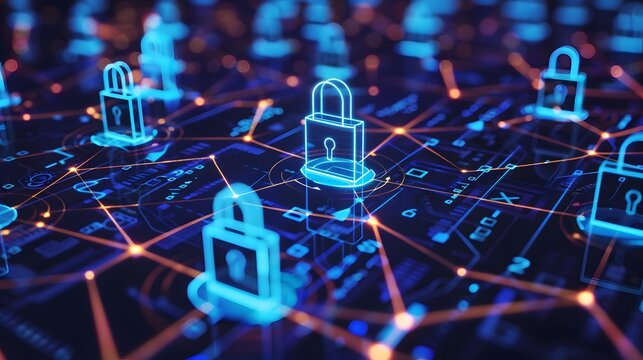





Here we will build a network intrusion detector, a predictive model capable of distinguishing between ‘bad’ connections, called intrusions or attacks, and ‘good’ or normal connections.

## **Data Set**

The dataset is from the KDD Cup 1999 dataset, which is widely used for intrusion detection system research. The dataset was designed to provide a benchmark for evaluating algorithms designed to detect various types of attacks in a network environment. The data includes normal connections as well as simulated intrusions, which are categorized into different types, such as Denial of Service (DoS), Probing, and Remote-to-Local (R2L) attacks.

Here's a breakdown of the attributes in the dataset you provided:
*   duration: Length of the connection in seconds.
*   protocol_type: The protocol used (e.g., TCP, UDP, ICMP).
*   service: The network service used (e.g., HTTP, FTP).
*   flag: Status of the connection (e.g., SF for "normal" connections)
*   src_bytes: Number of data bytes sent from the source.
*   dst_bytes: Number of data bytes sent to the destination.
*   land: A binary feature indicating if the connection is from the same source and destination IP.
*   wrong_fragment: Number of wrong fragments in the packet.
*   urgent: Number of urgent packets.
*   hot: A count of the number of hot indicators.
*   num_failed_logins: Number of failed login attempts.
*   logged_in: Whether the user is logged in (1 or 0).
*   lnum_compromised: The number of compromised systems.
*   lroot_shell: Binary flag indicating if the user has root shell access.
*   lsu_attempted: Number of successful user attempts.
*   lnum_root: Number of root-level actions.
*   lnum_file_creations: Number of files created during the session.
*   lnum_shells: Number of shell processes invoked.
*   lnum_access_files: Number of file access actions.
*   lnum_outbound_cmds: Number of outbound commands issued.
*   is_host_login: Indicates if it's a host login attempt.
*   is_guest_login: Indicates if it's a guest login attempt.
*   count: Number of connections to the same host.
*   srv_count: Number of connections to the same service.
*   serror_rate: The rate of connections with 'SYN' errors.
*   srv_serror_rate: The rate of service errors.
*   rerror_rate: The rate of connections with 'ACK' errors.
*   srv_rerror_rate: The rate of service-related errors.
*   same_srv_rate: Rate of connections with the same service.
*   diff_srv_rate: Rate of connections with different services.
*   srv_diff_host_rate: Rate of connections from different hosts for the same service.
*   dst_host_count: The number of connections to the destination host.
*   dst_host_srv_count: The number of connections to the destination service.
*   dst_host_same_srv_rate: Rate of connections to the same service on the destination host.
*   dst_host_diff_srv_rate: Rate of connections to different services on the destination host.
*   dst_host_same_src_port_rate: Rate of connections from the same source port to the destination host.
*   dst_host_srv_diff_host_rate: Rate of connections to different hosts for the same service.
*   dst_host_serror_rate: The rate of destination host connections with 'SYN' errors.
*   st_host_srv_serror_rate: The rate of service-related 'SYN' errors.
*   dst_host_rerror_rate: The rate of destination host connections with 'ACK' errors.
*   dst_host_srv_rerror_rate: The rate of service-related 'ACK' errors.

The label column indicates whether the connection is classified as normal or as a type of attack (e.g., DoS, Probe, R2L, U2R).

This dataset is often used to train and evaluate machine learning models for detecting malicious network activities. The features in the dataset can help build classifiers that predict whether a network connection is legitimate or suspicious based on the observed characteristics of the connection.

## **Data Loading and Preprocessing**

### **Import required Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras.models import Sequential,Model
from keras.layers import Input, Dense
from tensorflow.keras.layers import Dropout, BatchNormalization,GaussianNoise,LSTM
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,LearningRateScheduler,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.compose import ColumnTransformer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix,classification_report, roc_auc_score, roc_curve, auc,accuracy_score, precision_recall_fscore_support,precision_recall_curve
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
import time
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.losses import MeanAbsoluteError
from sklearn.utils.class_weight import compute_class_weight

### **Loading and Analysing basic information from data set**
We will begin by loading the dataset and analyzing the various types of attacks mentioned. Our goal is to explore the parameters that each attack depends on, providing a comprehensive understanding of how different attack types are influenced by specific factors

In [ ]:
# Load the data
df=pd.read_csv('kddcup99.csv')
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.00,0.00,0.0,0.0,normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal
494016,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal
494017,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal
494018,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal


In [ ]:
# Check the number of rows and columns
df.shape

(494020, 42)

In [ ]:
# Statistical summary
df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,lnum_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,494020.000000,4.940200e+05,4.940200e+05,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,...,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000
mean,47.979400,3.025616e+03,8.685308e+02,0.000045,0.006433,0.000014,0.034519,0.000152,0.148245,0.010212,...,232.471248,188.666052,0.753781,0.030906,0.601936,0.006684,0.176754,0.176443,0.058118,0.057412
std,707.747185,9.882191e+05,3.304003e+04,0.006673,0.134805,0.005510,0.782103,0.015520,0.355343,1.798328,...,64.744601,106.040205,0.410780,0.109259,0.481309,0.042133,0.380593,0.380920,0.230590,0.230141
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494020 entries, 0 to 494019
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494020 non-null  int64  
 1   protocol_type                494020 non-null  object 
 2   service                      494020 non-null  object 
 3   flag                         494020 non-null  object 
 4   src_bytes                    494020 non-null  int64  
 5   dst_bytes                    494020 non-null  int64  
 6   land                         494020 non-null  int64  
 7   wrong_fragment               494020 non-null  int64  
 8   urgent                       494020 non-null  int64  
 9   hot                          494020 non-null  int64  
 10  num_failed_logins            494020 non-null  int64  
 11  logged_in                    494020 non-null  int64  
 12  lnum_compromised             494020 non-null  int64  
 13 

In [ ]:
# Display the missing values
df.isnull().sum()

,0
duration,0
protocol_type,0
service,0
flag,0
src_bytes,0
dst_bytes,0
land,0
wrong_fragment,0
urgent,0
hot,0


As you can see in the above output there are no null vlaues in any of the columns

In [ ]:
# All the columns present in the data set
df.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'lnum_compromised', 'lroot_shell',
       'lsu_attempted', 'lnum_root', 'lnum_file_creations', 'lnum_shells',
       'lnum_access_files', 'lnum_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'label'],
      dtype='object')

In [ ]:
# Check for duplicates and drop them
df = df.drop_duplicates()
df.shape

(145585, 42)

The DataFrame has been cleaned by removing duplicate rows. It now contains 145,585 rows and 42 columns.

In [ ]:
#Create a new column 'category' in the DataFrame by applying a transformation on the 'label' column.
df.loc[:, 'category'] = df['label'].apply(lambda x: "normal" if x == "normal" else "attack")
df

<ipython-input-20-d9871291e556>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'category'] = df['label'].apply(lambda x: "normal" if x == "normal" else "attack")


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,category
0,0,tcp,http,SF,181,5450,0,0,0,0,...,1.0,0.0,0.11,0.00,0.00,0.00,0.0,0.0,normal,normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal,normal
2,0,tcp,http,SF,235,1337,0,0,0,0,...,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal,normal
3,0,tcp,http,SF,219,1337,0,0,0,0,...,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,0,tcp,http,SF,310,1881,0,0,0,0,...,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal,normal
494016,0,tcp,http,SF,282,2286,0,0,0,0,...,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal,normal
494017,0,tcp,http,SF,203,1200,0,0,0,0,...,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal,normal
494018,0,tcp,http,SF,291,1200,0,0,0,0,...,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal,normal


A new column category has been added to the DataFrame, categorizing each row as either "normal" or "attack" based on the value in the label column.

If the value in label is "normal", category is set to "normal". For all other values in label, category is set to "attack".

This column will be used further during EDA.

## **Exploratory Data Analysis**

Here, we analyze the dataset to explore the relationships between the fields, understand their correlations, and evaluate how strongly they influence the output.

label
spy                    2
perl                   3
phf                    4
multihop               7
ftp_write              8
loadmodule             9
rootkit               10
imap                  12
land                  19
warezmaster           20
buffer_overflow       30
guess_passwd          53
nmap                 158
pod                  206
portsweep            416
smurf                641
ipsweep              651
warezclient          893
satan                906
teardrop             918
back                 968
neptune            51820
normal             87831
Name: count, dtype: int64


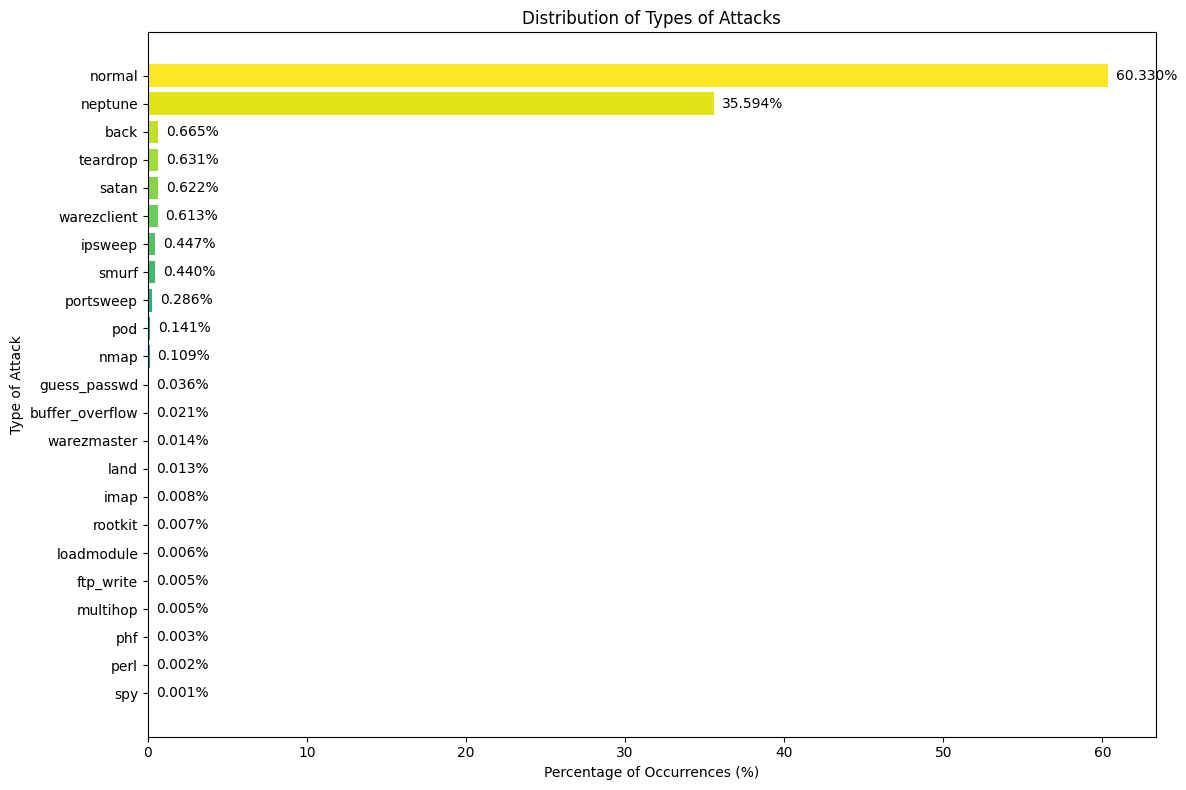

In [ ]:
# Disaplying different types of attacks
# Count the unique values and thier frequencies for the labels
label_counts= df['label'].value_counts().sort_values()
print(label_counts)
label_percentages = (label_counts / label_counts.sum()) * 100


# Define a color palette for the bars
colors = plt.cm.viridis(np.linspace(0, 1, len(label_counts)))

plt.figure(figsize=(12, 8))
bars = plt.barh(label_counts.index, label_percentages, color=colors)


for bar, percentage in zip(bars, label_percentages):
    plt.text(
        bar.get_width() + 0.5,
        bar.get_y() + bar.get_height() / 2,
        f"{percentage:.3f}%",
        va='center',
    )
# Plot the graph
plt.xlabel('Percentage of Occurrences (%)')
plt.ylabel('Type of Attack')
plt.title('Distribution of Types of Attacks')
plt.tight_layout()
plt.show()

The chart highlights that the majority of occurrences are categorized as "Normal" (60.333%) and "Neptune" (35.594%), with other types of attacks having significantly lower percentages. This information is useful for understanding the distribution and frequency of different types of network attacks.

<br>

We will first check how much percentage of the traffic in the given data set was normal and how much was considered as an attack.

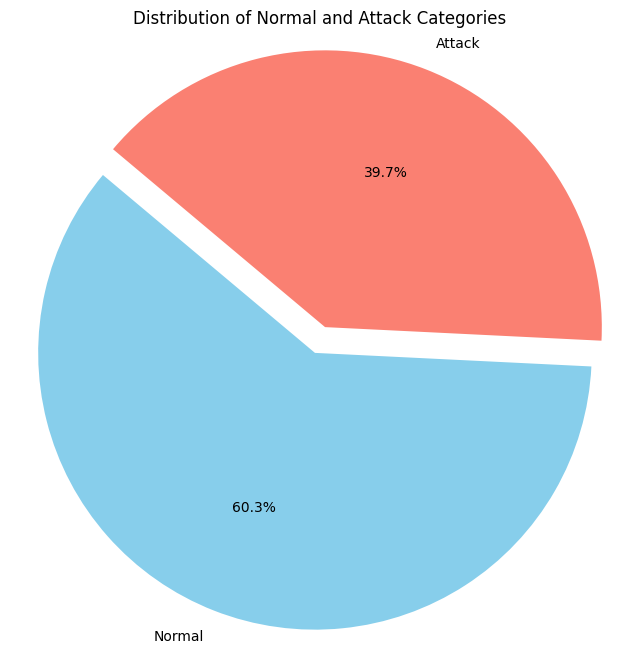

In [ ]:
normal_count = label_counts["normal"]
attack_count = sum(value for key, value in label_counts.items() if key != "normal")

# Data for pie chart
labels = ["Normal", "Attack"]
sizes = [normal_count, attack_count]
colors = ["skyblue", "salmon"]

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors,explode=(0.1, 0))
plt.title("Distribution of Normal and Attack Categories")
plt.axis("equal")
plt.show()


This chart highlights the proportion of normal versus attack categories.
'Normal' makes up 60.3% of the total while 'Attack' makes up 39.7% of the total.

<br>


Check for the descriptive statistics for numerical columns. Here we compute the descriptive statistics for the 'duration' column.

In [ ]:
# Compute descriptive statistics for the 'duration' column
descriptive_stats = df.groupby('category')['duration'].agg([
    'count', 'mean', 'std', 'min', 'max'
])

# Display results
print(descriptive_stats)

          count        mean          std  min    max
category                                            
attack    57754   45.480971  1054.282608    0  42448
normal    87831  188.934545  1320.960313    0  58329


<br>

Next, we will analyse the different protocal and flag type for both attack and normal category.


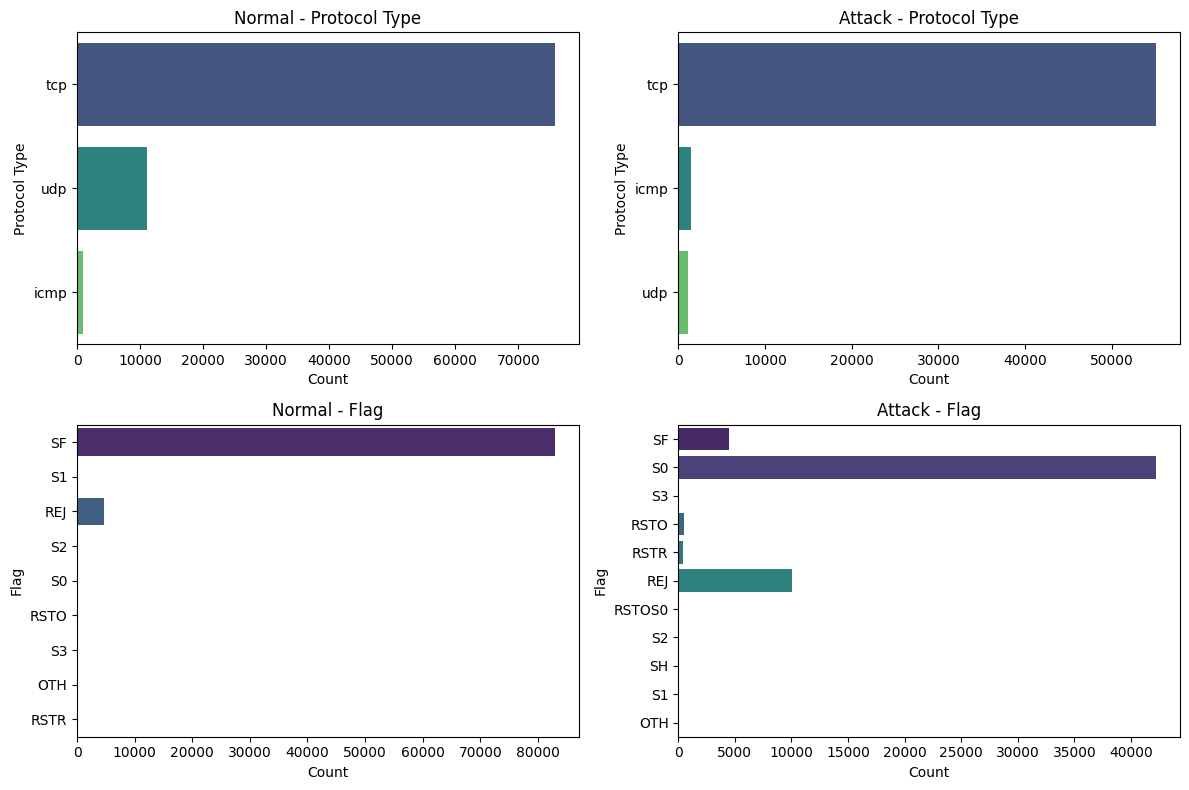

In [ ]:

# Filter data for normal and attack categories
normal_data = df[df['category'] == 'normal']
attack_data = df[df['category'] == 'attack']

# Create  subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Horizontal bar plot for 'protocol_type' (Normal)
sns.countplot(data=normal_data, y='protocol_type', ax=axes[0, 0], hue='protocol_type', palette='viridis', dodge=False, legend=False)
axes[0, 0].set_title('Normal - Protocol Type')
axes[0, 0].set_ylabel('Protocol Type')
axes[0, 0].set_xlabel('Count')

# Horizontal bar plot for 'protocol_type' (Attack)
sns.countplot(data=attack_data, y='protocol_type', ax=axes[0, 1], hue='protocol_type', palette='viridis', dodge=False, legend=False)
axes[0, 1].set_title('Attack - Protocol Type')
axes[0, 1].set_ylabel('Protocol Type')
axes[0, 1].set_xlabel('Count')

# Horizontal bar plot for 'flag' (Normal)
sns.countplot(data=normal_data, y='flag', ax=axes[1, 0], hue='flag', palette='viridis', dodge=False, legend=False)
axes[1, 0].set_title('Normal - Flag')
axes[1, 0].set_ylabel('Flag')
axes[1, 0].set_xlabel('Count')

# Horizontal bar plot for 'flag' (Attack)
sns.countplot(data=attack_data, y='flag', ax=axes[1, 1], hue='flag', palette='viridis', dodge=False, legend=False)
axes[1, 1].set_title('Attack - Flag')
axes[1, 1].set_ylabel('Flag')
axes[1, 1].set_xlabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()

The above charts comparison of network traffic data between normal and attack scenarios through four bar charts. These charts highlight significant differences in protocol usage and flag distribution. In the first chart, representing Normal - Protocol Type, TCP dominates with over 70,000 counts, followed by UDP with around 15,000 counts, and a minimal count for ICMP. Contrastingly, the Attack - Protocol Type chart shows TCP as the majority but with a reduced count of over 50,000, ICMP with approximately 10,000 counts, and a negligible count for UDP. The second set of charts examines flag distributions. In the Normal - Flag chart, the SF flag is overwhelmingly predominant with over 80,000 counts, while REJ and other flags register minimal counts. The Attack - Flag chart depicts a different picture, with the S0 flag being the most frequent at around 40,000 counts, REJ with about 10,000 counts, and a small count for SF.

Normal traffic predominantly utilizes the TCP protocol and SF flag, indicating a stable and consistent network behavior. However, in attack scenarios, while TCP remains the dominant protocol, there is a notable increase in ICMP usage, potentially indicating ping flood or other ICMP-based attacks. The shift in flag distribution, with S0 becoming the most frequent in attack traffic, suggests that attackers might be initiating but not completing TCP connections, a common trait in SYN flood attacks. These observations are crucial for network security analysis, helping to identify and understand the behavioral patterns of normal versus malicious traffic, and enhancing the ability to detect and mitigate potential threats effectively.

<br>

We visualize the frequency distribution of different services used in the "normal" and "attack" categories, highlighting their occurrence counts. This helps identify patterns or anomalies in service usage between the two categories.

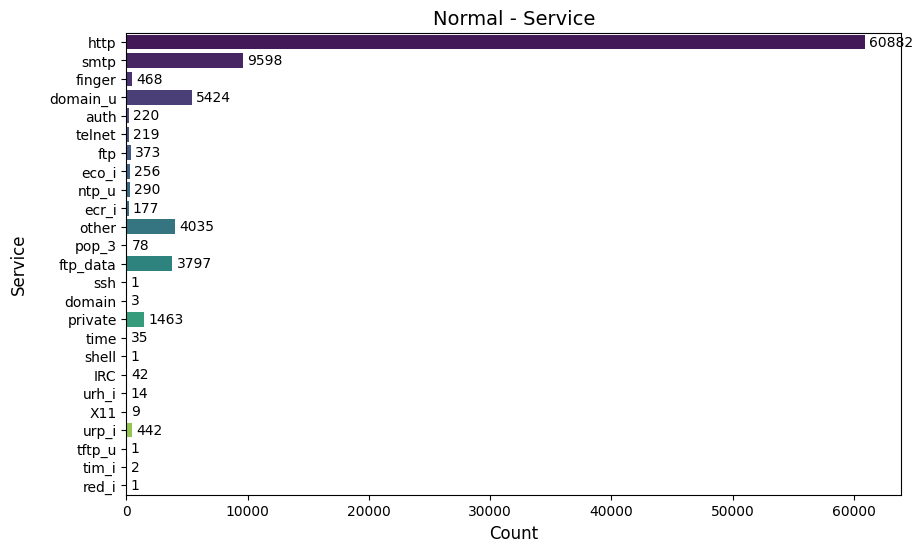

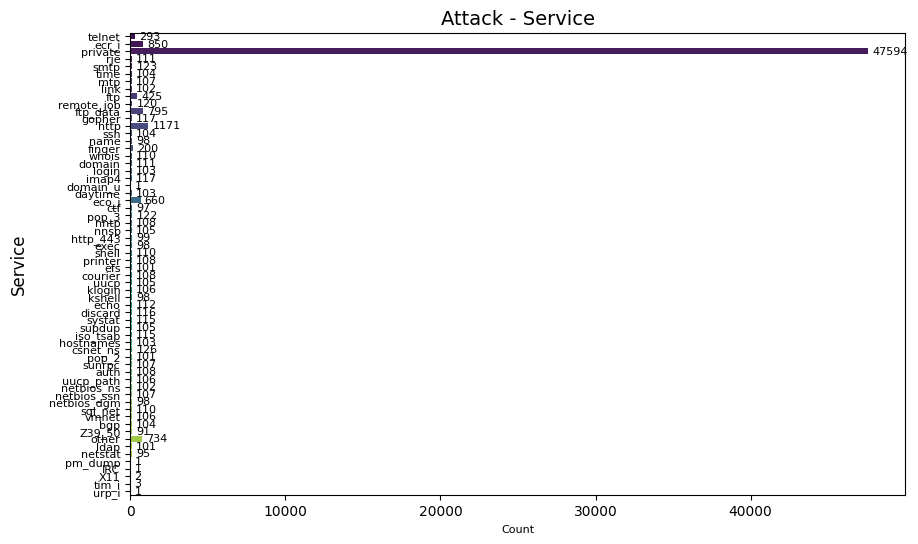

In [ ]:
# Plot the bar graph for different services for attack and normak category
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=normal_data, y='service', hue='service', palette='viridis', dodge=False, legend=False)
plt.title('Normal - Service', fontsize=14)
plt.ylabel('Service', fontsize=12, labelpad=15)
plt.xlabel('Count', fontsize=12)
plt.yticks(fontsize=10)


for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10, padding=3)

plt.show()

# Plot for 'attack' data
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=attack_data, y='service', hue='service', palette='viridis', dodge=False, legend=False)
plt.title('Attack - Service', fontsize=14)
plt.ylabel('Service', fontsize=12, labelpad=15)
plt.xlabel('Count', fontsize=8)
plt.yticks(fontsize=8)

# Add count on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=8, padding=3)

plt.show()

Above charts display the count of various services within normal network traffic.

Several services have very low counts, such as ssh, shell, tftp_u, and red_i, each with only 1 occurrence, indicating minimal usage in normal conditions. The chart highlights the predominance of web-related services (http and smtp) in the dataset, reflecting typical network usage patterns.


*   HTTP and SMTP: The dominance of these services indicates their crucial roles in everyday network operations, primarily web browsing and email communication.
*   Low Usage Services: The very low counts of certain services suggest they are rarely used under normal conditions, which could help in identifying anomalies when these services are accessed more frequently.
*   Diversity of Services: The presence of a wide range of services, even with lower counts, highlights the variety of normal network activities, which is essential for comprehensive network monitoring and security analysis.

Understanding these patterns can aid in distinguishing between normal and potentially malicious activities by providing a benchmark for normal service usage.

<br>

Calculate and display the mean values for src_bytes and dst_bytes (representing the number of bytes transferred) for each category ("normal" and "attack"). This helps analyze the average data transfer volume for both incoming and outgoing traffic in each category.

In [ ]:
# Descriptive statistics for the number of bytes transfered
descriptive_stats = df.groupby('category').agg(
    src_bytes_mean=('src_bytes', 'mean'),
    dst_bytes_mean=('dst_bytes', 'mean')
)

# Display results
print(descriptive_stats)

          src_bytes_mean  dst_bytes_mean
category                                
attack      18223.731620     1550.618156
normal       1270.259885     3720.643611


<br>

We will next analyze the behavior of failed login attempts by examining the num_failed_logins feature for both "normal" and "attack" traffic. For normal traffic, the focus is on understanding how frequently users fail to log in and identifying typical patterns of behavior. For attack traffic, the aim is to observe whether attacks exhibit unusual or significantly higher rates of failed login attempts. To achieve this, we will visualizes and compare the percentage distribution of failed logins for both categories, providing insights into potential behavioral differences that could be used for anomaly detection or classification purposes.

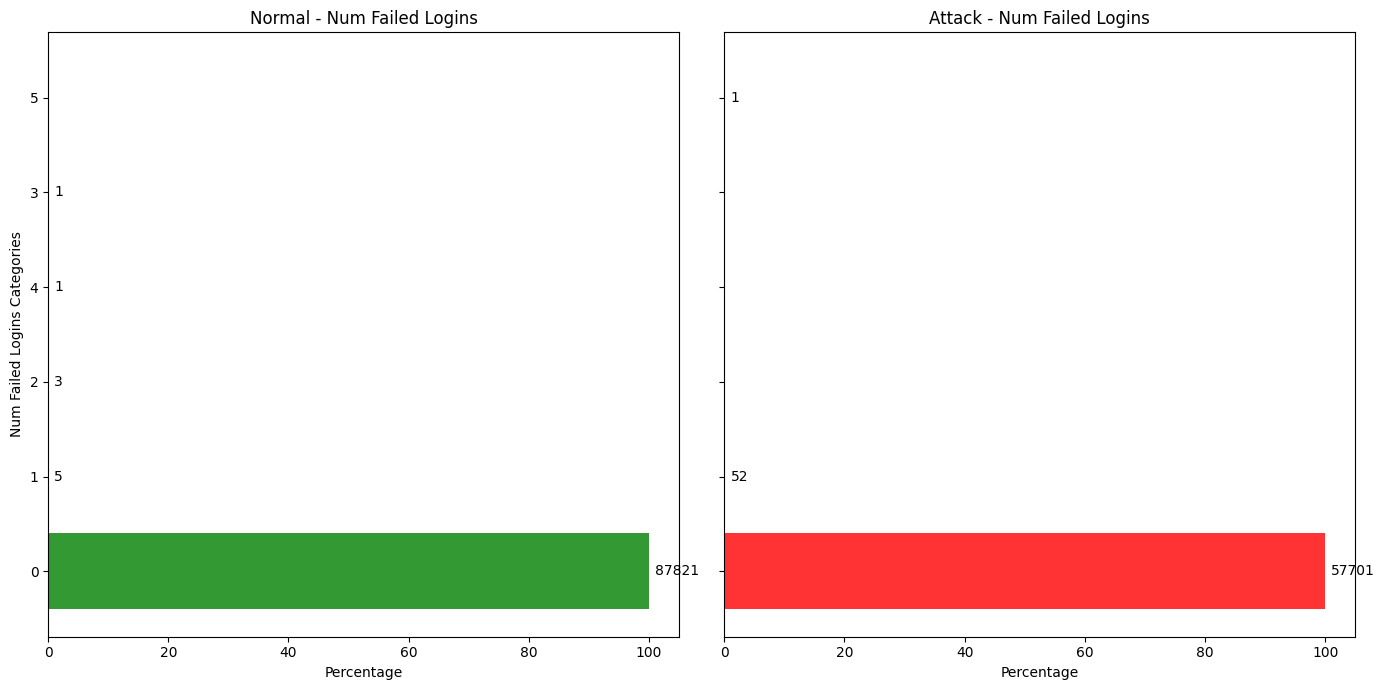

In [ ]:
normal_failed_logins = normal_data['num_failed_logins'].value_counts(normalize=True) * 100
normal_failed_logins_counts = normal_data['num_failed_logins'].value_counts()

attack_failed_logins = attack_data['num_failed_logins'].value_counts(normalize=True) * 100
attack_failed_logins_counts = attack_data['num_failed_logins'].value_counts()

# Create subplots for bar charts
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

# Bar chart for normal category
bars_normal = axes[0].barh(
    normal_failed_logins.index.astype(str),
    normal_failed_logins,
    color='green',
    alpha=0.8
)
axes[0].set_title('Normal - Num Failed Logins')
axes[0].set_xlabel('Percentage')
axes[0].set_ylabel('Num Failed Logins Categories')
axes[0].invert_yaxis()

# Add count labels on bars for normal
for bar, count in zip(bars_normal, normal_failed_logins_counts):
    axes[0].text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, str(count), va='center')

# Bar chart for attack category
bars_attack = axes[1].barh(
    attack_failed_logins.index.astype(str),
    attack_failed_logins,
    color='red',
    alpha=0.8
)
axes[1].set_title('Attack - Num Failed Logins')
axes[1].set_xlabel('Percentage')
axes[1].invert_yaxis()

# Add count labels on bars for attack
for bar, count in zip(bars_attack, attack_failed_logins_counts):
    axes[1].text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, str(count), va='center')

# Adjust layout
plt.tight_layout()
plt.show()



*   Both charts show that the majority of failed login attempts fall within the 0-1 failed login category.
*   Under normal conditions, there are significantly more failed logins (87,821) compared to during an attack (57,701).Despite the attacks causing failed logins, they don't significantly exceed the number of normal failed logins.
*  The high number of failed logins under normal conditions suggests regular usage, whereas the noticeable yet smaller number during attacks might indicate attempts to breach security without drawing excessive attention.

These insights are essential for understanding how login failures differ between normal operations and attack scenarios, helping in fine-tuning security measures.

<br>

Here we visualize the distribution of the logged_in status (whether a user is logged in or not) for both the "normal" and "attack" categories. It uses pie charts to show the percentage of logged-in vs. not logged-in status in each category, helping to identify differences in user authentication behavior between normal and attack traffic.

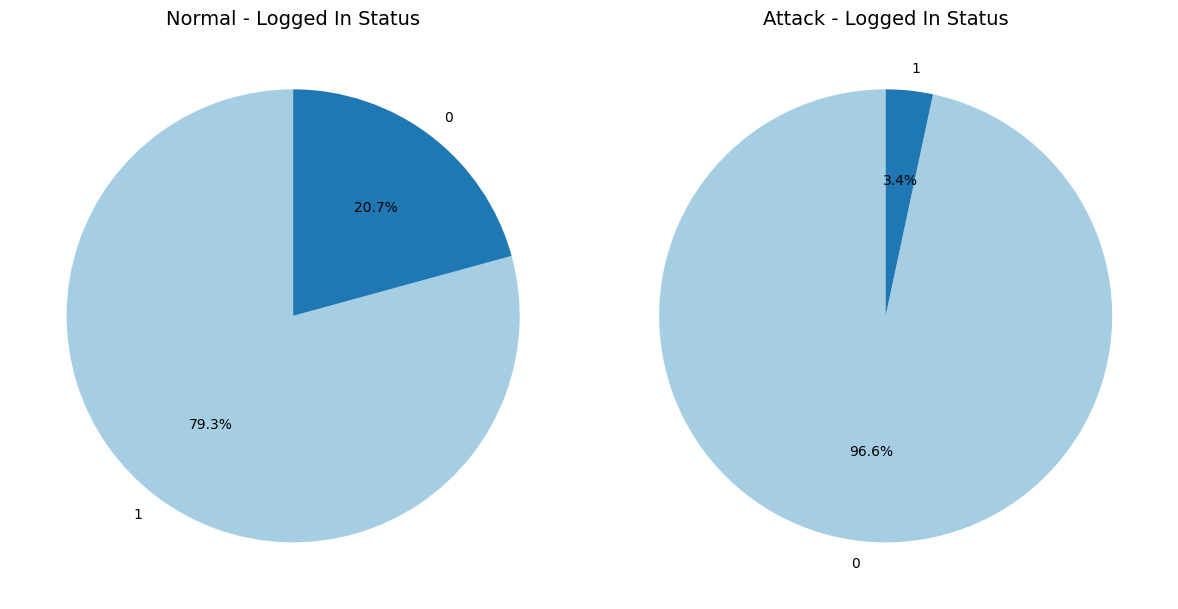

In [ ]:

# Calculate value counts for the 'logged_in' column
normal_logged_in = normal_data['logged_in'].value_counts(normalize=True) * 100  # Convert to percentages
attack_logged_in = attack_data['logged_in'].value_counts(normalize=True) * 100  # Convert to percentages

# Set up the figure for subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart for 'logged_in' in the normal category
axes[0].pie(
    normal_logged_in,
    labels=normal_logged_in.index,
    autopct='%1.1f%%',
    colors=plt.cm.Paired.colors,
    startangle=90,
)
axes[0].set_title('Normal - Logged In Status', fontsize=14)

# Pie chart for 'logged_in' in the attack category
axes[1].pie(
    attack_logged_in,
    labels=attack_logged_in.index,
    autopct='%1.1f%%',
    colors=plt.cm.Paired.colors,
    startangle=90,
)
axes[1].set_title('Attack - Logged In Status', fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()



*   In normal traffic, a significant majority of users (79.3%) are logged in, indicating that legitimate users are more likely to be authenticated.
*   In attack traffic, an overwhelming majority of users (96.6%) are not logged in, suggesting that most attacks are carried out by unauthenticated users.


*   This stark contrast in logged-in status between normal and attack traffic can be used to identify and mitigate potential security threats by focusing on unauthenticated access attempts.












<br>

Here we are analysing distribution of three features—lnum_compromised, lnum_file_creations, and lnum_root—for both "normal" and "attack" categories using box plots. These plots help to identify the spread, central tendency, and outliers of these features within each category, providing insights into potential anomalies or differences between normal and attack behaviors. The custom outlier properties highlight any extreme values in the data for further analysis.

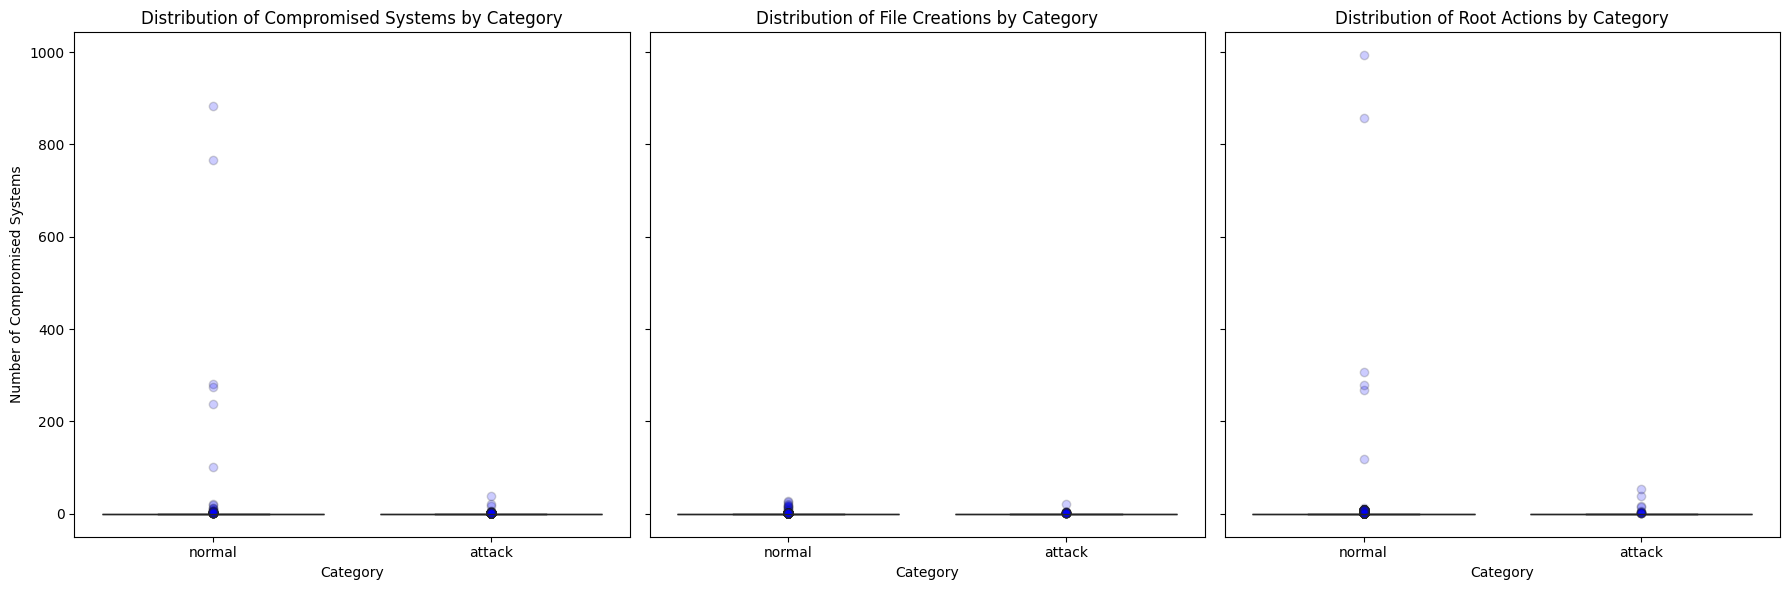

In [ ]:

# Set up axes for subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Define the features to plot
features = ['lnum_compromised', 'lnum_file_creations', 'lnum_root']
titles = ['Compromised Systems', 'File Creations', 'Root Actions']
colors = {'normal': 'green', 'attack': 'red'}

# Customize outlier properties
flierprops = {
    'marker': 'o',
    'markersize': 6,
    'markerfacecolor': 'blue',
    'alpha': 0.2
}

# Create box plots for each feature
for i, feature in enumerate(features):
    sns.boxplot(
        data=df,
        x='category',
        y=feature,
        ax=axes[i],
        hue='category',
        palette=colors,
        flierprops=flierprops,
        legend=False
    )
    axes[i].set_title(f'Distribution of {titles[i]} by Category', fontsize=12)
    axes[i].set_xlabel('Category', fontsize=10)
    axes[i].set_ylabel(f'Number of {titles[i]}', fontsize=10)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

*   Normal conditions show a broader range of values for both
compromised systems and root actions, indicating more variability and some extreme cases in normal activity.
*   Both normal and attack categories have outliers in the number of compromised systems and root actions. However, the normal category has more and higher outliers, which could suggest occasional high-activity events.


*  The minimal differences and lack of significant outliers in file creation activity between normal and attack scenarios suggest that this metric may not be as indicative of attacks as the other metrics.

These insights can help in understanding the behavior of normal versus attack traffic and in identifying patterns that distinguish between these scenarios. Such analysis is crucial for developing effective security measures and improving threat detection strategies.

<br>

The below code is to visualize the distribution of different features (specifically, lroot_shell, lsu_attempted, and lnum_access_files) across the "normal" and "attack" categories in the dataset.

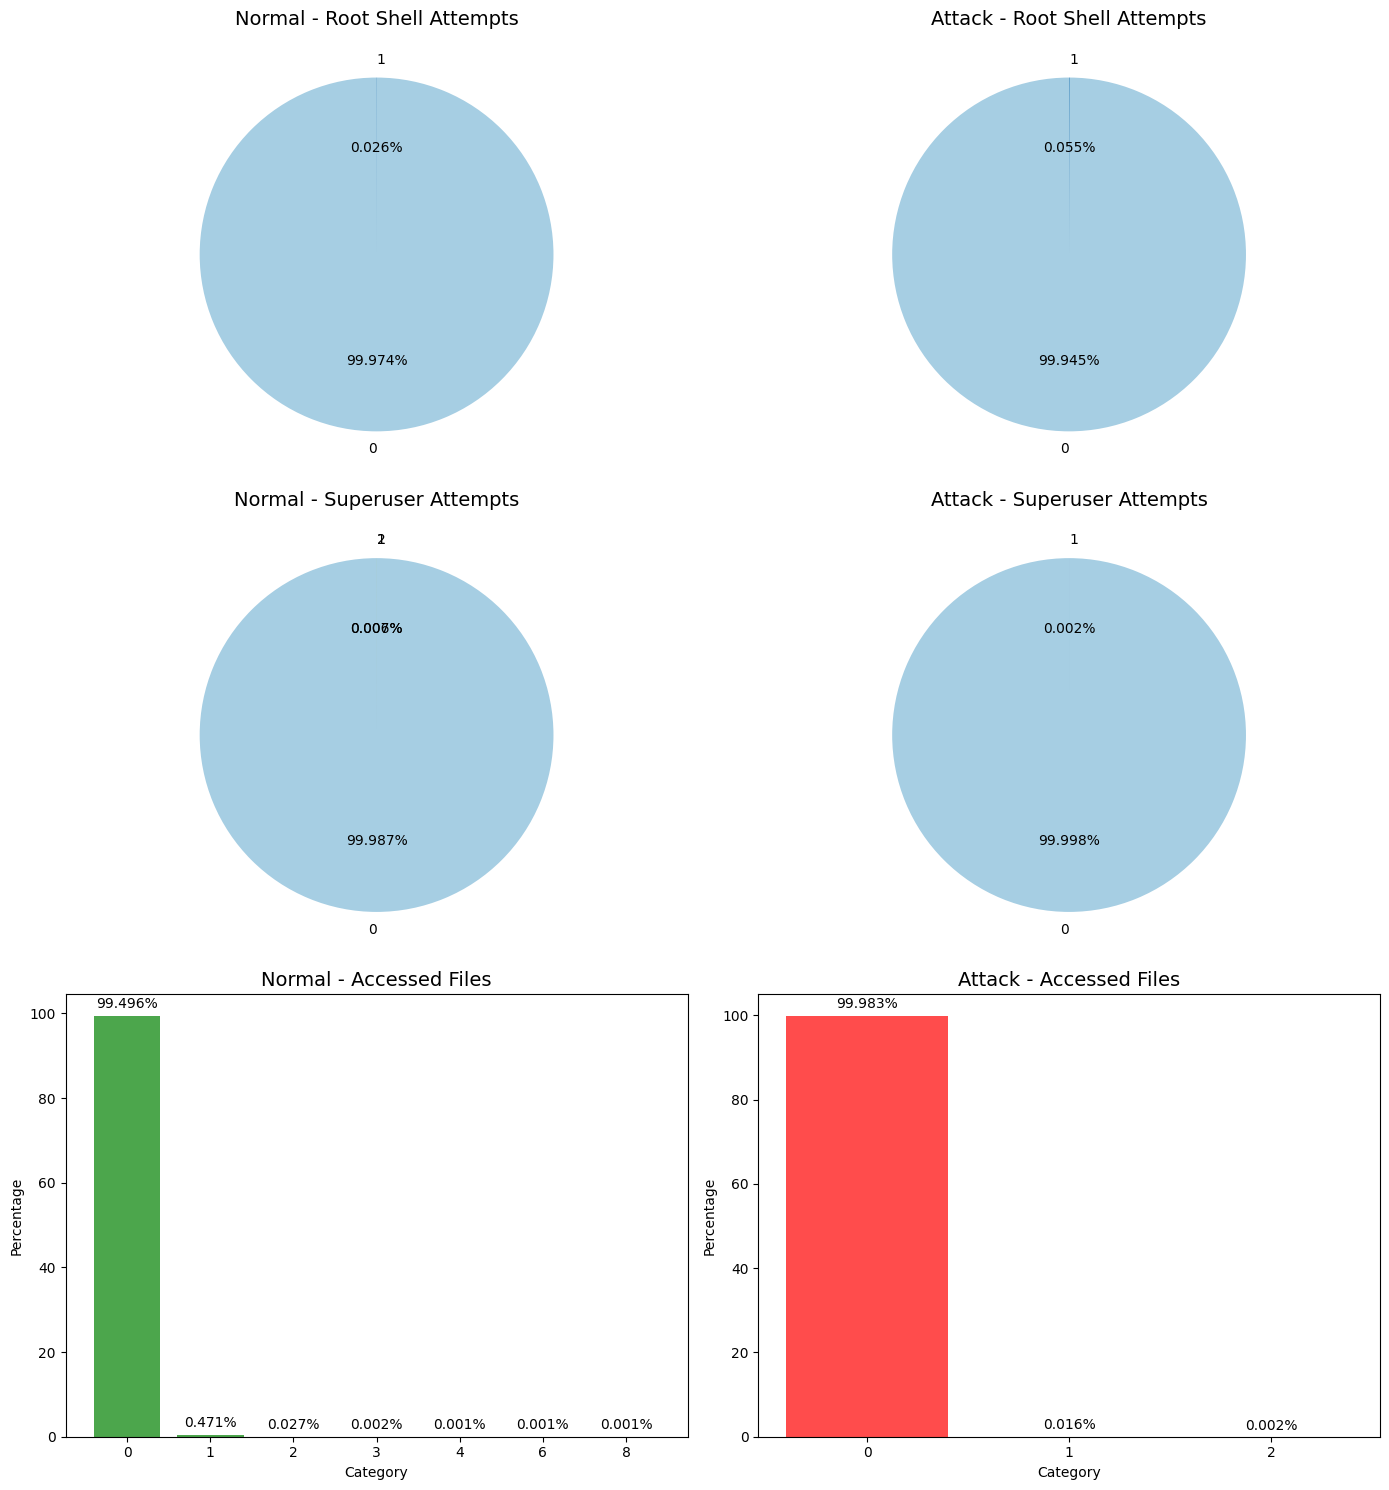

In [ ]:

# Columns to visualize
columns = ['lroot_shell', 'lsu_attempted', 'lnum_access_files']
titles = {
    'lroot_shell': 'Root Shell Attempts',
    'lsu_attempted': 'Superuser Attempts',
    'lnum_access_files': 'Accessed Files',
}
# Set up the figure for subplots
fig, axes = plt.subplots(len(columns), 2, figsize=(14, 5 * len(columns)))

for i, col in enumerate(columns):
    # Calculate value counts for normal and attack categories
    normal_counts = normal_data[col].value_counts(normalize=True) * 100  # Convert to percentages
    attack_counts = attack_data[col].value_counts(normalize=True) * 100  # Convert to percentages

    if col == 'lnum_access_files':
        # Bar chart for 'normal' category
        bars_normal = axes[i, 0].bar(
            normal_counts.index.astype(str),
            normal_counts,
            color='green', alpha=0.7
        )
        axes[i, 0].set_title(f'Normal - {titles[col]}', fontsize=14)
        axes[i, 0].set_xlabel('Category', fontsize=10)
        axes[i, 0].set_ylabel('Percentage', fontsize=10)

        # Add percentage labels on top of each bar for 'normal'
        for bar in bars_normal:
            height = bar.get_height()
            axes[i, 0].text(
                bar.get_x() + bar.get_width() / 2, height + 1,
                f'{height:.3f}%', ha='center', va='bottom', fontsize=10
            )

        # Bar chart for 'attack' category
        bars_attack = axes[i, 1].bar(
            attack_counts.index.astype(str),
            attack_counts,
            color='red', alpha=0.7
        )
        axes[i, 1].set_title(f'Attack - {titles[col]}', fontsize=14)
        axes[i, 1].set_xlabel('Category', fontsize=10)
        axes[i, 1].set_ylabel('Percentage', fontsize=10)

        # Add percentage labels on top of each bar for 'attack'
        for bar in bars_attack:
            height = bar.get_height()
            axes[i, 1].text(
                bar.get_x() + bar.get_width() / 2, height + 1,
                f'{height:.3f}%', ha='center', va='bottom', fontsize=10
            )
    else:
        # Pie chart for other features
        axes[i, 0].pie(
            normal_counts,
            labels=normal_counts.index,
            autopct='%1.3f%%',
            colors=plt.cm.Paired.colors,
            startangle=90,
        )
        axes[i, 0].set_title(f'Normal - {titles[col]}', fontsize=14)

        axes[i, 1].pie(
            attack_counts,
            labels=attack_counts.index,
            autopct='%1.3f%%',
            colors=plt.cm.Paired.colors,
            startangle=90,
        )
        axes[i, 1].set_title(f'Attack - {titles[col]}', fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()


1. Root Shell Attempts:
*   Both normal and attack categories have a very high percentage of data points with no root shell attempts (99.974% for normal and 99.945% for attack).
*   The percentage of root shell attempts is slightly higher in the attack category (0.055%) compared to the normal category (0.026%).

2. Superuser Attempts:
*  Both normal and attack categories have a very high percentage of data points with no superuser attempts (99.987% for normal and 99.998% for attack).
*   The percentage of superuser attempts is slightly higher in the normal category (0.008%) compared to the attack category (0.002%).

3. Accessed Files:
*   Both normal and attack categories have a very high percentage of data points with no accessed files (99.496% for normal and 99.983% for attack).
*   The distribution of accessed files is more varied in the normal category, with small percentages spread across categories 1 to 8.

In the attack category, the distribution is limited to categories 1 and 2, with very small percentages (0.016% and 0.002%, respectively).

These insights suggest that while the majority of data points in both categories have no root shell attempts, superuser attempts, or accessed files, there are slight differences in the distribution of these features between the normal and attack categories. This information can be valuable for distinguishing between normal and attack traffic based on these specific features.

<br>

We will drop the 'category' column as it is no longer required.

In [ ]:
df.drop(columns='category', inplace=True)

<ipython-input-20-33c49b766832>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns='category', inplace=True)


## **Model Development**

Now we will build and train deep learning models using Keras to solve the problem at hand. The models are designed as follows:
1.   Model 1: Time-Instance Based Model

  This model processes the data individually at each time instance, considering only the current point of data without any temporal dependencies. It is designed to capture the behavior of the data at each snapshot.
2.   Model 2: Time-Series Model

  This model treats the data as a time series, leveraging the temporal dependencies between data points. It is built to capture patterns over time, using architectures like LSTMs.
3. Model 3: Anomaly Detection Model

  This model is designed for anomaly detection, focusing on identifying unusual or abnormal data points. It learns patterns from normal data and uses this knowledge to detect deviations from expected behavior, marking them as anomalies.

These models collectively aim to address the problem from different perspectives, utilizing deep learning techniques to improve performance and detection accuracy.

### **Splitting and initial preprocessing of data**

The code identifies the numeric and non-numeric columns in the dataset, excluding the target column (`label`). It then calculates the frequency of categories in the target column and identifies underrepresented categories (those with fewer than 30 occurrences), which can be addressed later for class imbalance.

In [ ]:
# segregate numerical and categorical columns
target_column = 'label'
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
non_numeric_columns = df.select_dtypes(exclude=['int64', 'float64']).columns
non_numeric_columns = non_numeric_columns[non_numeric_columns != 'label']

value_counts = df[target_column].value_counts()

categories_to_duplicate = value_counts[value_counts < 30].index


<br>

We'll try to address class imbalance by duplicating samples from underrepresented categories. For each category identified as underrepresented (with fewer than 30 occurrences), it calculates how many additional samples are needed to reach a minimum of 30. It then randomly samples the necessary number of rows from that category and appends them to the dataset.

In [ ]:
for category in categories_to_duplicate:
    samples_to_duplicate = 30 - value_counts[category]
    duplicate_samples = df[df[target_column] == category].sample(samples_to_duplicate, replace=True, random_state=42)
    df = pd.concat([df, duplicate_samples])


# Separate features (X) and target (y)
X = df.drop(columns=[target_column])
y = df[target_column]

<br>

Now we perform a stratified split of the dataset into training, validation, and test sets to ensure that the distribution of the target variable (y) is preserved across the splits.

In [ ]:

# Stratified split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, stratify=y_temp, random_state=42)


<br>

We'll now perform label encoding on both the target variable (`y`) and the categorical features in the dataset to prepare the data for machine learning models.

First, we concatenate the training, validation, and test sets (`X_train`, `X_val`, `X_test`) and the corresponding target labels (`y_train`, `y_val`, `y_test`) back together into `X_all` and `y_all`. This ensures that all labels are accounted for in the encoding process.

The target variable (`y_all`) is then encoded using a `LabelEncoder` to transform the labels into numerical values. This encoding is done on the entire dataset (training, validation, and test) to maintain consistency. After encoding, the `y_all` array is split back into the respective train, validation, and test sets.

Next, the categorical features (non-numeric columns) in the dataset are label-encoded using the `LabelEncoder`. The code first combines the categorical features from all sets, fits the encoder on the combined data, and then applies the transformation to each individual set (`X_train`, `X_val`, `X_test`). This ensures that the encoding is consistent across all data subsets, preventing any mismatches when applying the model. The intention behind this process is to transform categorical data into a format suitable for machine learning algorithms, which typically require numerical input.

In [ ]:

# Concatenate all sets to ensure all labels are accounted for
X_all = pd.concat([X_train, X_val, X_test], axis=0)
y_all = pd.concat([y_train, y_val, y_test], axis=0)

label_encoder_X = LabelEncoder()
label_encoder_y = LabelEncoder()

# Fit and transform on the entire data
y_all = label_encoder_y.fit_transform(y_all)

# Split back into train, validation, and test sets
y_train, y_val, y_test = y_all[:len(y_train)], y_all[len(y_train):len(y_train)+len(y_val)], y_all[len(y_train)+len(y_val):]

# Fit LabelEncoder for categorical features on the entire dataset
for column in non_numeric_columns:
    # Fit and transform on the entire dataset
    combined_data = pd.concat([X_train[column], X_val[column], X_test[column]], axis=0)
    label_encoder_X.fit(combined_data)

    # Transform for each set
    X_train[column] = label_encoder_X.transform(X_train[column])
    X_val[column] = label_encoder_X.transform(X_val[column])
    X_test[column] = label_encoder_X.transform(X_test[column])



<br>

Now scale the numeric features to a standardized range while maintaining the integrity of the categorical features. This is a common preprocessing step to ensure that machine learning models perform optimally, especially when using algorithms sensitive to feature scaling (e.g., neural networks, support vector machines). Here we use `MinMaxScaler()` which scales the numeric features to a range between 0 and 1.

The function `normalize_data` is defined to normalize the numeric columns of a given dataset (`X_data`).The normalized numeric data is then combined with the non-numeric columns (which are unchanged) to form the complete normalized dataset (`X_data_normalized`). This is done using `pd.concat()` along the columns axis (`axis=1`).


In [ ]:
scaler = MinMaxScaler()

def normalize_data(X_data, numeric_cols, non_numeric_columns):
    numeric_data = X_data[numeric_cols]
    normalized_numeric_data = scaler.fit_transform(numeric_data)
    X_data_normalized = pd.DataFrame(normalized_numeric_data, columns=numeric_cols, index=X_data.index)
    return pd.concat([X_data_normalized, X_data[non_numeric_columns]], axis=1)

X_train_normalized = normalize_data(X_train, numeric_columns, non_numeric_columns)
X_val_normalized = normalize_data(X_val, numeric_columns, non_numeric_columns)
X_test_normalized = normalize_data(X_test, numeric_columns, non_numeric_columns)

# Output final datasets for inspection
print("X_train shape:", X_train_normalized.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val_normalized.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test_normalized.shape)
print("y_test shape:", y_test.shape)

X_train shape: (116632, 41)
y_train shape: (116632,)
X_val shape: (20411, 41)
y_val shape: (20411,)
X_test shape: (8748, 41)
y_test shape: (8748,)


Resampling is done inorder to maintain the balance in the samples in each category.
SMOTE (Synthetic Minority Over-sampling Technique), a technique used to address class imbalance in the dataset by generating synthetic samples for the underrepresented classes in the training data. As a result, the training set becomes more balanced, with synthetic examples created for the underrepresented class.
The main intention is to handle class imbalance in the training data by generating synthetic examples for the minority class using the SMOTE technique. This is important because many machine learning algorithms perform poorly when one class is significantly underrepresented compared to the other(s). By creating synthetic samples, the model can better learn the characteristics of the minority class, improving its ability to generalize and make accurate predictions for both classes.

In [ ]:
# Apply SMOTE Resampling (for numeric features)
smote = SMOTE(random_state=42)

# Apply SMOTE to resample the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train_normalized, y_train)

# Output final resampled datasets for inspection
print("X_train shape after resampling:", X_train_smote.shape)
print("y_train shape after resampling:", y_train_smote.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


X_train shape after resampling: (1616072, 41)
y_train shape after resampling: (1616072,)


The code starts by creating an instance of SMOTE from the `imblearn` library.The `smote.fit_resample()` method is then applied to the normalized training dataset (`X_train_normalized`) and the corresponding target labels (`y_train`).

<br>


Plotting the sample before and after resampling

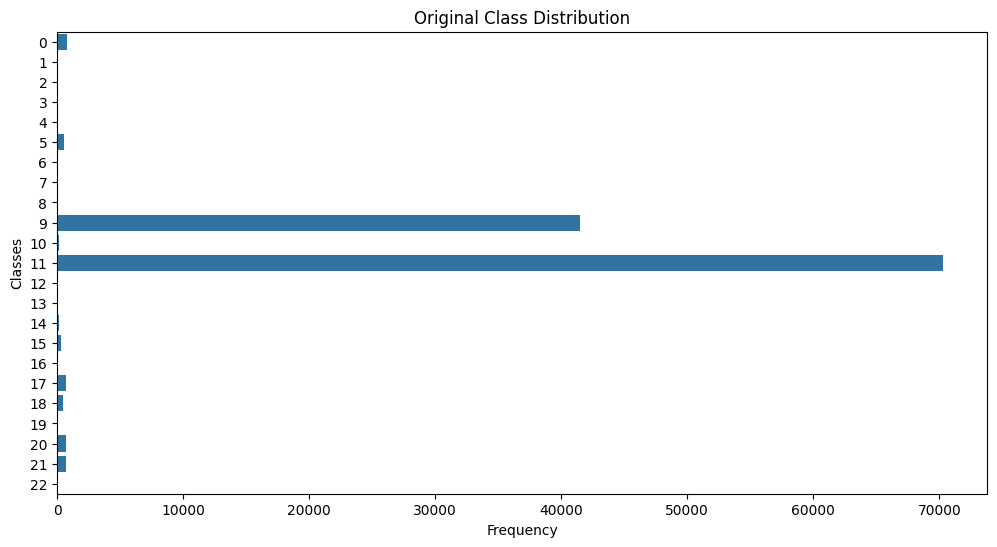

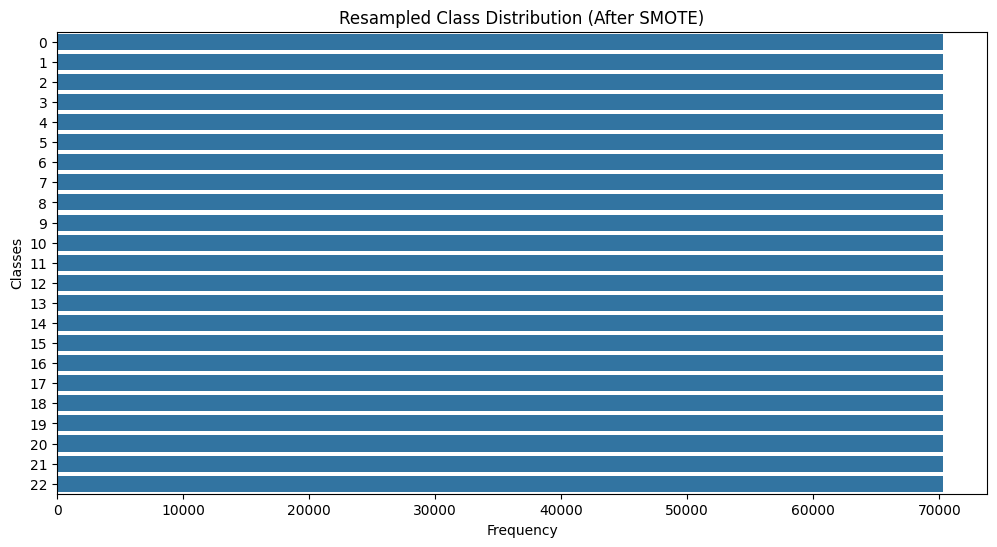

In [ ]:

# Plot the original class distribution
plt.figure(figsize=(12, 6))
sns.countplot(y=y_train)  # Use y for horizontal bar chart
plt.title('Original Class Distribution')
plt.xlabel('Frequency')
plt.ylabel('Classes')
plt.show()

# Plot the class distribution after SMOTE resampling (horizontal bars)
plt.figure(figsize=(12, 6))
sns.countplot(y=y_train_smote)  # Use y for horizontal bar chart
plt.title('Resampled Class Distribution (After SMOTE)')
plt.xlabel('Frequency')
plt.ylabel('Classes')
plt.show()

### **Model 1: Feed-forward network**

Model 1 is a deep neural network for multi-class classification with 23 categories. It has two hidden layers with ReLU activation, L2 regularization, and dropout for regularization. The model uses Adam optimizer with a reduced learning rate and is compiled with categorical crossentropy loss. Early stopping and learning rate reduction on plateau are used as callbacks to prevent overfitting and improve convergence. The target labels are one-hot encoded, and the model is trained on SMOTE-resampled and normalized data. Training stops early if validation loss doesn't improve for 5 epochs.

In [ ]:

# Define the model
model_1 = Sequential()
model_1.add(Dense(64, activation='relu', input_shape=(X_train_smote.shape[1],), kernel_regularizer=l2(0.01))) # First hidden layer
model_1.add(Dropout(0.4))  # dropout for regularization
model_1.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01))) # Second hidden layer
model_1.add(Dropout(0.4))
model_1.add(Dense(23, activation='softmax')) # Output layer

# Compile the model with reduced learning rate
optimizer = Adam(learning_rate=0.0001)
model_1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Reduce learning rate on plateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# One-hot encode the target variable y_train_smote
y_train_smote_one_hot = to_categorical(y_train_smote, num_classes=23)
y_val_one_hot = to_categorical(y_val, num_classes=23)

# Train the model
history_1 = model_1.fit(
    X_train_smote,
    y_train_smote_one_hot,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_normalized, y_val_one_hot),
    callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
50503/50503 ━━━━━━━━━━━━━━━━━━━━ 109s 2ms/step - accuracy: 0.2373 - loss: 2.7827 - val_accuracy: 0.3668 - val_loss: 1.2782 - learning_rate: 1.0000e-04
Epoch 2/50
50503/50503 ━━━━━━━━━━━━━━━━━━━━ 99s 2ms/step - accuracy: 0.6560 - loss: 1.2754 - val_accuracy: 0.4634 - val_loss: 1.0574 - learning_rate: 1.0000e-04
Epoch 3/50
50503/50503 ━━━━━━━━━━━━━━━━━━━━ 144s 2ms/step - accuracy: 0.7508 - loss: 1.0225 - val_accuracy: 0.5112 - val_loss: 0.9401 - learning_rate: 1.0000e-04
Epoch 4/50
50503/50503 ━━━━━━━━━━━━━━━━━━━━ 139s 2ms/step - accuracy: 0.7917 - loss: 0.8907 - val_accuracy: 0.5203 - val_loss: 0.8922 - learning_rate: 1.0000e-04
Epoch 5/50
50503/50503 ━━━━━━━━━━━━━━━━━━━━ 144s 2ms/step - accuracy: 0.8154 - loss: 0.8093 - val_accuracy: 0.5242 - val_loss: 0.8656 - learning_rate: 1.0000e-04
Epoch 6/50
50503/50503 ━━━━━━━━━━━━━━━━━━━━ 141s 2ms/step - accuracy: 0.8295 - loss: 0.7529 - val_accuracy: 0.5280 - val_loss: 0.8305 - learning_rate: 1.0000e-04
Epoch 7/50
50503/50503 ━━━━━━

In [ ]:
model_1.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 64)                  │           2,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 23)                  │             759 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,583 (64.78 KB)

 Trainable params: 5,527 (21.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,056 (43.19 KB)

<br>

We'll try to visualize the training and validation performance of Model 1 over epochs.

Accuracy Plot: Displays both training accuracy and validation accuracy across epochs to assess how well the model is learning and generalizing to unseen data.

Loss Plot: Displays both training loss and validation loss across epochs, helping to monitor whether the model is overfitting or improving its performance.

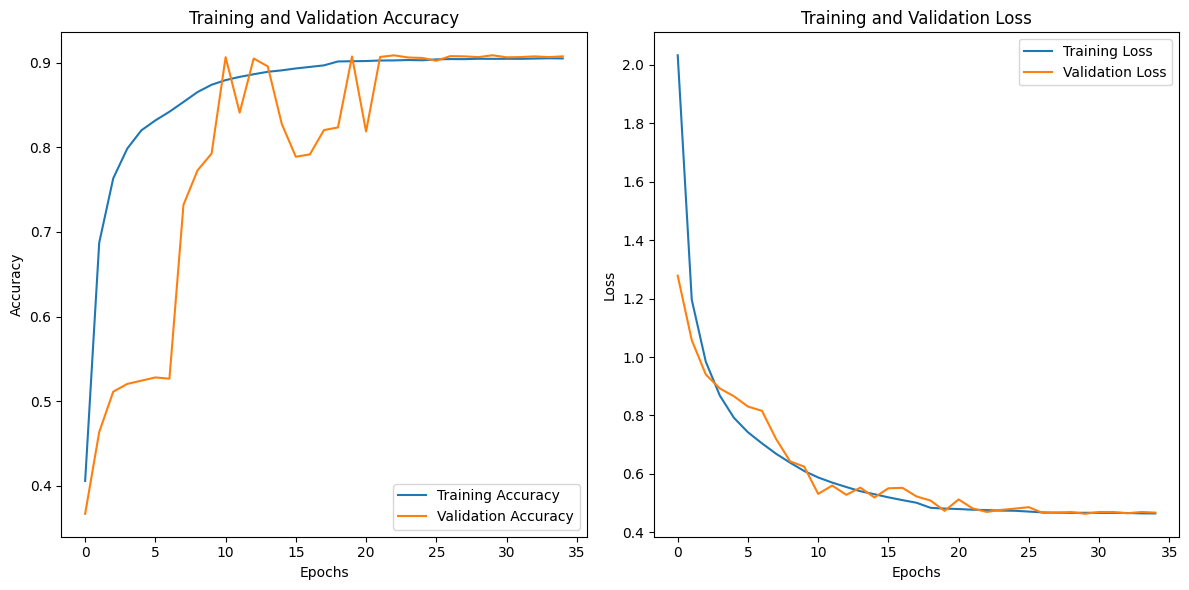

In [ ]:
plt.figure(figsize=(12, 6))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()




*   The training accuracy increases steadily and plateaus around 0.9, indicating that the model is learning well from the training data.
*   The validation accuracy increases rapidly and fluctuates between 0.8 and 0.9, suggesting that the model generalizes well to the validation data but has some variability.
*   The training loss decreases steadily and plateaus around 0.4, indicating that the model's predictions are becoming more accurate over time.
*   The validation loss decreases rapidly and fluctuates around 0.5, suggesting that the model's performance on the validation data is relatively stable but has some variability.

The fluctuations in validation accuracy and loss could indicate some overfitting, but overall, the model appears to be performing well.

<br>

Prepare and evaluate the model's predictions on the test set

In [ ]:
y_test_one_hot = to_categorical(y_test, num_classes=23)

# Predictions (as probabilities and labels)
y_pred_proba = model_1.predict(X_test_normalized)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


The code one-hot encodes the test labels and then uses the trained model to predict class probabilities for the test data. These probabilities are converted into predicted labels (y_pred), while the true labels are also converted into class labels (y_true). This allows for the calculation of evaluation metrics like accuracy and loss to assess the model's performance.

<br>

 Classification report includes detailed metrics like precision, recall, F1-score, and support for each class. This helps evaluate the model's performance across all classes.

In [ ]:
num_classes = len(np.unique(y_true))
print(num_classes)

# Generate target names dynamically to match the actual number of classes
target_names = [f"Class {i}" for i in range(num_classes)]

# Display Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

23

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.29      0.98      0.45        58
     Class 1       0.04      0.50      0.07         2
     Class 2       0.12      1.00      0.22         2
     Class 3       0.14      1.00      0.25         3
     Class 4       0.67      1.00      0.80         2
     Class 5       0.97      0.97      0.97        39
     Class 6       1.00      1.00      1.00         2
     Class 7       0.67      1.00      0.80         2
     Class 8       0.67      1.00      0.80         2
     Class 9       1.00      1.00      1.00      3109
    Class 10       0.12      0.89      0.21         9
    Class 11       1.00      0.85      0.92      5270
    Class 12       1.00      1.00      1.00         2
    Class 13       1.00      1.00      1.00         2
    Class 14       0.69      0.92      0.79        12
    Class 15       1.00      1.00      1.00        25
    Class 16       0.03      1.00      0.06         2


*   Precision: Some classes, like Class 6, Class 9, and Class 12, have very high precision (1.00), meaning the model makes very few false positives for these classes.
*   Recall: Many classes have perfect recall (1.00), meaning the model correctly identifies all instances of those classes. However, classes like Class 1, Class 16, and Class 19 have low recall, indicating the model struggles to identify these instances correctly.
*   F1-Score: This metric balances precision and recall. Classes like Class 6, Class 9, and Class 12 show perfect F1-scores, indicating strong overall performance. On the other hand, classes like Class 1, Class 19, and Class 22 have very low F1-scores, showing poor performance in both precision and recall.

The model performs well for some classes but struggles with others, particularly those with very few samples. The high recall for many classes suggests that the model is able to correctly identify most instances of those classes. However, there is room for improvement, especially in terms of precision for underrepresented classes.






<br>

ROC-AUC curves are used to evaluate the performance of classification models, particularly when dealing with imbalanced datasets or multi-class problems.

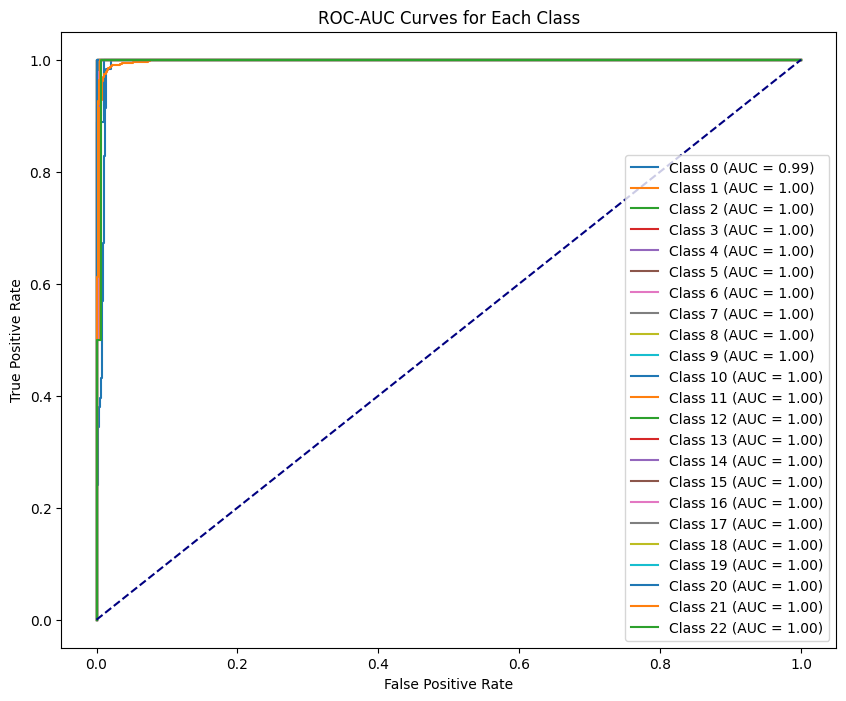


ROC-AUC Scores:
Class 0: 0.99
Class 1: 1.00
Class 2: 1.00
Class 3: 1.00
Class 4: 1.00
Class 5: 1.00
Class 6: 1.00
Class 7: 1.00
Class 8: 1.00
Class 9: 1.00
Class 10: 1.00
Class 11: 1.00
Class 12: 1.00
Class 13: 1.00
Class 14: 1.00
Class 15: 1.00
Class 16: 1.00
Class 17: 1.00
Class 18: 1.00
Class 19: 1.00
Class 20: 1.00
Class 21: 1.00
Class 22: 1.00
Micro-Average: 1.00


In [ ]:
# Compute ROC-AUC for each class
n_classes = y_test_one_hot.shape[1]
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC-AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_one_hot.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")  # Diagonal
plt.title("ROC-AUC Curves for Each Class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Print ROC-AUC scores
print("\nROC-AUC Scores:")
for i in range(n_classes):
    print(f"Class {i}: {roc_auc[i]:.2f}")
print(f"Micro-Average: {roc_auc['micro']:.2f}")


The AUC values for most classes are 1.00, indicating perfect classification performance for those classes. This suggests the model is highly effective in distinguishing between these classes.

The ROC curve for each class being close to the top-left corner further confirms the model's good performance.

The high AUC values across multiple classes highlight the model's robustness and ability to accurately classify data across different categories.

<br>

In [ ]:

accuracy=accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')  # Weighted accounts for class imbalance
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print overall metrics
print("\nOverall Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Overall Metrics:
Accuracy: 0.9112
Precision: 0.9822
Recall: 0.9112
F1 Score: 0.9382


The model exhibits strong overall performance with an accuracy of 91.12%, meaning it correctly classifies about 91% of instances. The precision is 98.22%, indicating that when the model predicts a positive class, it is correct most of the time. The recall is 91.12%, showing that it successfully identifies 91% of all actual positive cases. The F1 score, which balances precision and recall, is 93.82%, indicating a solid trade-off between the two metrics. Overall, these metrics suggest that the model performs well in terms of both identifying positive cases and minimizing false positives.

<br>

### **Model 2: Time Series Network**

This model uses a Long Short-Term Memory (LSTM) network to handle the data as a time-series problem. The main objective is to capture temporal dependencies and patterns from the sequential data, leveraging the LSTM's ability to process and learn from time-based relationships between features.

The LSTM-based architecture is intended to take advantage of the sequential nature of the data, potentially improving model performance by learning patterns over time (e.g., trends or relationships between features at different time steps). Regularization techniques like dropout and L2 regularization help combat overfitting, and early stopping ensures efficient training. The model is optimized for multi-class classification, with careful adjustments to learning rates to ensure stable training.

In [ ]:

timesteps = 1
features_per_timestep = X_train_smote.shape[1]

# Reshape training, validation, and test datasets
X_train_reshaped = X_train_smote.values.reshape((X_train_smote.shape[0], timesteps, features_per_timestep))
X_val_reshaped = X_val_normalized.values.reshape((X_val_normalized.shape[0], timesteps, features_per_timestep))
X_test_reshaped = X_test_normalized.values.reshape((X_test_normalized.shape[0], timesteps, features_per_timestep))

# Define the LSTM model
model_lstm = Sequential()

# First LSTM layer
model_lstm.add(LSTM(64, activation='tanh', input_shape=(timesteps, features_per_timestep),
                    kernel_regularizer=l2(0.01), return_sequences=True))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.5))

# Second LSTM layer
model_lstm.add(LSTM(32, activation='tanh', kernel_regularizer=l2(0.01)))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.5))

# Output layer
model_lstm.add(Dense(23, activation='softmax'))

# Compile the model with reduced learning rate
optimizer = Adam(learning_rate=0.00001)
model_lstm.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Reduce learning rate on plateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# Train the LSTM model
history_lstm = model_lstm.fit(
    X_train_reshaped,
    y_train_smote_one_hot,
    epochs=30,
    batch_size=32,
    validation_data=(X_val_reshaped, y_val_one_hot),
    callbacks=[early_stopping, reduce_lr]
)

# Print model summary
model_lstm.summary()

# Evaluate on test data
results = model_lstm.evaluate(X_test_reshaped, y_test_one_hot, verbose=0)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
50503/50503 ━━━━━━━━━━━━━━━━━━━━ 246s 5ms/step - accuracy: 0.3168 - loss: 3.2762 - val_accuracy: 0.8272 - val_loss: 1.1437 - learning_rate: 1.0000e-05
Epoch 2/30
50503/50503 ━━━━━━━━━━━━━━━━━━━━ 285s 5ms/step - accuracy: 0.7577 - loss: 1.0948 - val_accuracy: 0.8611 - val_loss: 0.7508 - learning_rate: 1.0000e-05
Epoch 3/30
50503/50503 ━━━━━━━━━━━━━━━━━━━━ 257s 5ms/step - accuracy: 0.8439 - loss: 0.7157 - val_accuracy: 0.7737 - val_loss: 0.6372 - learning_rate: 1.0000e-05
Epoch 4/30
50503/50503 ━━━━━━━━━━━━━━━━━━━━ 236s 5ms/step - accuracy: 0.8789 - loss: 0.5596 - val_accuracy: 0.9097 - val_loss: 0.5440 - learning_rate: 1.0000e-05
Epoch 5/30
50503/50503 ━━━━━━━━━━━━━━━━━━━━ 257s 4ms/step - accuracy: 0.8974 - loss: 0.4732 - val_accuracy: 0.9140 - val_loss: 0.4953 - learning_rate: 1.0000e-05
Epoch 6/30
50503/50503 ━━━━━━━━━━━━━━━━━━━━ 257s 4ms/step - accuracy: 0.9080 - loss: 0.4210 - val_accuracy: 0.9220 - val_loss: 0.4351 - learning_rate: 1.0000e-05
Epoch 7/30
50503/50503 ━━━━━

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 1, 64)               │          27,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 23)                  │             759 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,703 (475.41 KB)

 Trainable params: 40,503 (158.21 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 81,008 (316.44 KB)

Test Loss: 0.3302328884601593
Test Accuracy: 0.9310699701309204


The LSTM model processes data reshaped into 3D arrays to accommodate its time-series requirements. It consists of two LSTM layers: the first with 64 units and `return_sequences=True` to pass outputs to the next layer, and the second with 32 units as the final sequence-processing layer. Both layers use tanh activation, L2 regularization to prevent overfitting, and 0.5 dropout for additional regularization. Batch normalization is applied after each LSTM layer to stabilize and speed up training. The output layer uses a dense structure with 23 units and `softmax` activation for multi-class classification. Compiled with the Adam optimizer at a low learning rate (`0.00001`) and categorical_crossentropy loss, the model incorporates early stopping (patience of 5) and dynamic learning rate adjustment to optimize training. The model is trained for up to 30 epochs, with validation monitoring, and is evaluated on a test set for performance.

<br>

Plotting Accuracy and Loss function curve.

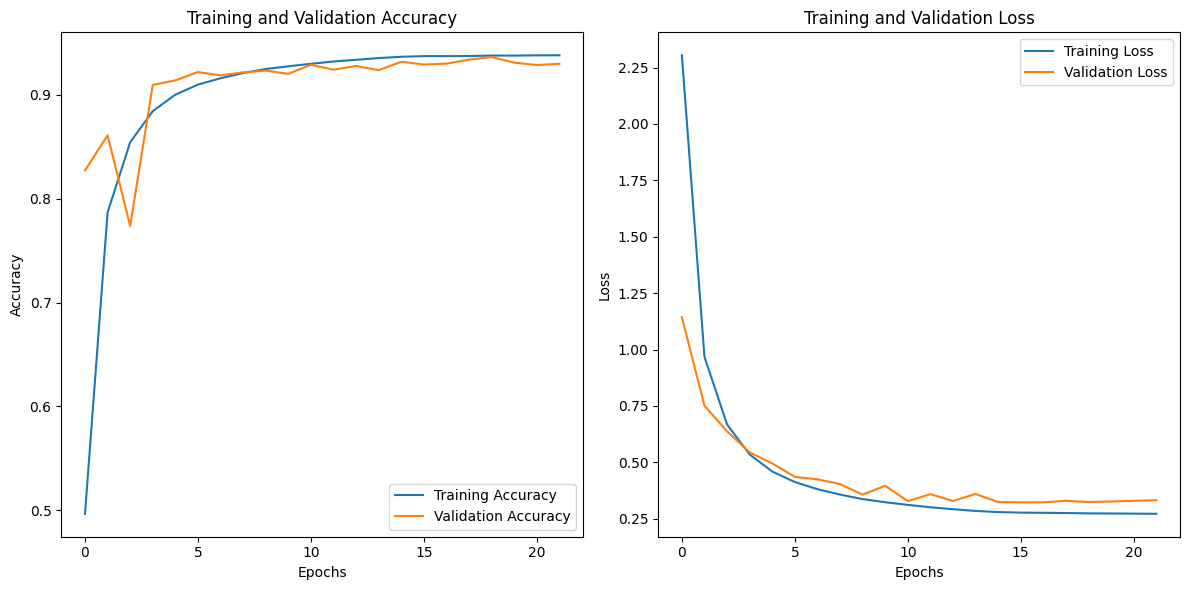

In [ ]:
plt.figure(figsize=(12, 6))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


The model demonstrates strong learning capabilities, with rapid improvements in accuracy and loss during the first few epochs. Training and validation accuracy rise quickly to around 0.95 and 0.9, respectively, while losses drop significantly, indicating effective error minimization. The close alignment of training and validation metrics suggests minimal overfitting and good generalization to unseen data. Slight fluctuations in validation metrics highlight opportunities for fine-tuning to improve stability. Overall, the model performs well, achieving high accuracy and low loss, suitable for the task.

<br>

The code converts true labels to one-hot encoding, generates predicted probabilities and labels from the LSTM model, and extracts the true and predicted class indices for evaluation.

In [ ]:
y_test_one_hot = to_categorical(y_test, num_classes=23)

# Predictions
y_pred_proba = model_lstm.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)


274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
num_classes = len(np.unique(y_true))  # Count unique classes in true labels
print(num_classes)

target_names = [f"Class {i}" for i in range(num_classes)]

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

23

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.32      0.98      0.48        58
     Class 1       0.17      0.50      0.25         2
     Class 2       0.06      1.00      0.12         2
     Class 3       0.60      1.00      0.75         3
     Class 4       1.00      1.00      1.00         2
     Class 5       0.88      0.97      0.93        39
     Class 6       1.00      1.00      1.00         2
     Class 7       0.25      1.00      0.40         2
     Class 8       0.05      1.00      0.09         2
     Class 9       1.00      1.00      1.00      3109
    Class 10       0.33      1.00      0.50         9
    Class 11       1.00      0.89      0.94      5270
    Class 12       1.00      1.00      1.00         2
    Class 13       0.67      1.00      0.80         2
    Class 14       1.00      0.92      0.96        12
    Class 15       0.89      1.00      0.94        25
    Class 16       0.03      1.00      0.06         2


The classification report highlights the model's strong overall performance, achieving 93% accuracy and a weighted F1-score of 0.95, driven by excellent results for majority classes like Class 9 and 11. However, performance for minority classes is inconsistent, with low precision and F1-scores despite high recall, indicating challenges in handling class imbalance. The macro-average F1-score of 0.63 reflects moderate performance across all classes, suggesting room for improvement in minority class predictions. Overall, the model effectively handles major classes but could benefit from strategies to address imbalanced data.

<br>



ROC and AUC curves

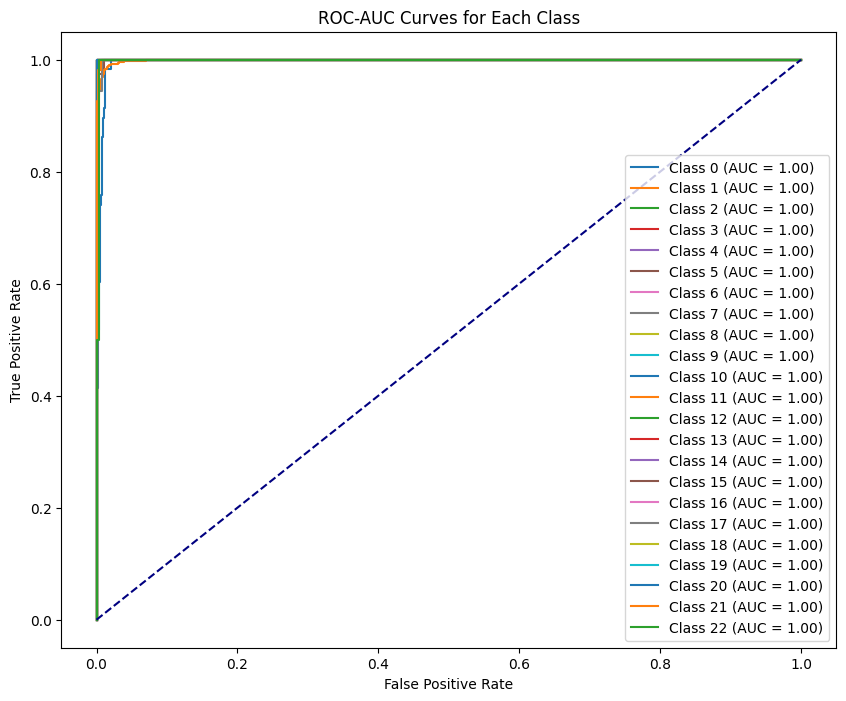


ROC-AUC Scores:
Class 0: 1.00
Class 1: 1.00
Class 2: 1.00
Class 3: 1.00
Class 4: 1.00
Class 5: 1.00
Class 6: 1.00
Class 7: 1.00
Class 8: 1.00
Class 9: 1.00
Class 10: 1.00
Class 11: 1.00
Class 12: 1.00
Class 13: 1.00
Class 14: 1.00
Class 15: 1.00
Class 16: 1.00
Class 17: 1.00
Class 18: 1.00
Class 19: 1.00
Class 20: 1.00
Class 21: 1.00
Class 22: 1.00
Micro-Average: 1.00


In [ ]:
# Compute ROC-AUC for each class
n_classes = y_test_one_hot.shape[1]
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC-AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_one_hot.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")  # Diagonal
plt.title("ROC-AUC Curves for Each Class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Print ROC-AUC scores
print("\nROC-AUC Scores:")
for i in range(n_classes):
    print(f"Class {i}: {roc_auc[i]:.2f}")
print(f"Micro-Average: {roc_auc['micro']:.2f}")


In [ ]:
accuracy=accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')  # Weighted accounts for class imbalance
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print overall metrics
print("\nOverall Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Overall Metrics:
Accuracy: 0.9311
Precision: 0.9831
Recall: 0.9311
F1 Score: 0.9510


The model demonstrates strong performance with a high accuracy of 93.11%, precision of 98.31%, recall of 93.11%, and an F1-score of 95.10%. These metrics indicate effective classification with a good balance between precision and recall, making the model both reliable and consistent in its predictions.

<br>

### **Model 3: Anomaly detection**

Anomaly detection involves identifying data points that deviate significantly from normal patterns, which may indicate errors, fraud, or other irregularities. This process is critical in domains such as cybersecurity, fraud detection, and predictive maintenance. Autoencoders, a type of neural network, are widely used for anomaly detection. They learn to reconstruct normal data patterns during training, and high reconstruction errors on unseen data indicate anomalies.

In [ ]:
# Load the dataset
data = pd.read_csv('kddcup99.csv')

# Define non-numeric columns and the label column
non_numeric_columns = ['protocol_type', 'service', 'flag']
label_column = 'label'

# Encode categorical variables
for col in non_numeric_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Convert the label column to binary: 0 for "normal", 1 for all others
data[label_column] = data[label_column].apply(lambda x: 0 if x == 'normal' else 1)

# Split features and labels
X = data.drop(columns=[label_column])
y = data[label_column]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check class distribution
class_counts = pd.Series(y).value_counts()
print("Class Distribution:\n", class_counts)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

print(f"Training set distribution:\n{pd.Series(y_train).value_counts()}")
print(f"Test set distribution:\n{pd.Series(y_test).value_counts()}")

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Filter out only "normal" data for training (label = 0)
X_normal = X_train[y_train == 0]
y_normal = y_train[y_train == 0]

# Define the autoencoder
autoencoder = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(X_train.shape[1], activation='tanh')
])

autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.summary()

checkpoint = ModelCheckpoint('autoencoder_best_model.keras',
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta = 0,
                              patience = 5,
                              verbose = 1,
                              restore_best_weights=True)
# Train the autoencoder using only "normal" data
history = autoencoder.fit(
    X_normal, X_normal,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_split=0.1,
    class_weight=class_weights_dict,
    verbose=1,
    callbacks=[checkpoint, earlystopping]
)


Class Distribution:
 label
1    396707
0     97267
Name: count, dtype: int64
Training set distribution:
label
1    277631
0     68150
Name: count, dtype: int64
Test set distribution:
label
1    119076
0     29117
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           2,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 41)                  │           2,665 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,617 (41.47 KB)

 Trainable params: 10,617 (41.47 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
237/240 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3495
Epoch 1: val_loss improved from inf to 0.22423, saving model to autoencoder_best_model.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3485 - val_loss: 0.2242
Epoch 2/50
237/240 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2246
Epoch 2: val_loss improved from 0.22423 to 0.20771, saving model to autoencoder_best_model.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2245 - val_loss: 0.2077
Epoch 3/50
225/240 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2142
Epoch 3: val_loss improved from 0.20771 to 0.19732, saving model to autoencoder_best_model.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2141 - val_loss: 0.1973
Epoch 4/50
230/240 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2027
Epoch 4: val_loss improved from 0.19732 to 0.19506, saving model to autoencoder_best_model.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2027 - val_loss: 0.1951
Epoch 5/50
234/240 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/s

The code prepares the KDD Cup 1999 dataset for anomaly detection by encoding non-numeric features (`protocol_type`, `service`, `flag`) using `LabelEncoder` and converting the target variable into binary labels: `0` for "normal" and `1` for anomalies. It standardizes the features with `StandardScaler` for better model performance and checks the class distribution to address the inherent data imbalance. The dataset is then split into training and testing sets (80-20), and class weights are calculated to ensure proper handling of underrepresented classes during training.

The autoencoder is trained exclusively on "normal" data to learn normal patterns, enabling it to identify anomalies based on reconstruction errors. Its architecture includes encoding layers that reduce dimensionality, a bottleneck layer for feature compression, and decoding layers to reconstruct the input. Dropout regularization prevents overfitting, while ReLU activation handles non-linearity in hidden layers, and tanh is used in the output layer for standardized data. The model is compiled with the Adam optimizer and Mean Absolute Error (MAE) loss. Training employs callbacks like `ModelCheckpoint` for saving the best weights and `EarlyStopping` to halt training if validation loss stops improving. This ensures an efficient and robust anomaly detection system.

The code aims to build and train an autoencoder for anomaly detection using the KDD Cup 1999 dataset. The autoencoder learns to reconstruct normal data patterns, and reconstruction errors on unseen data will be used to identify anomalies. Through standardization, class weighting, and callbacks, the implementation ensures robust and efficient training tailored for an imbalanced dataset.

<br>

Plotting Accuracy and Loss

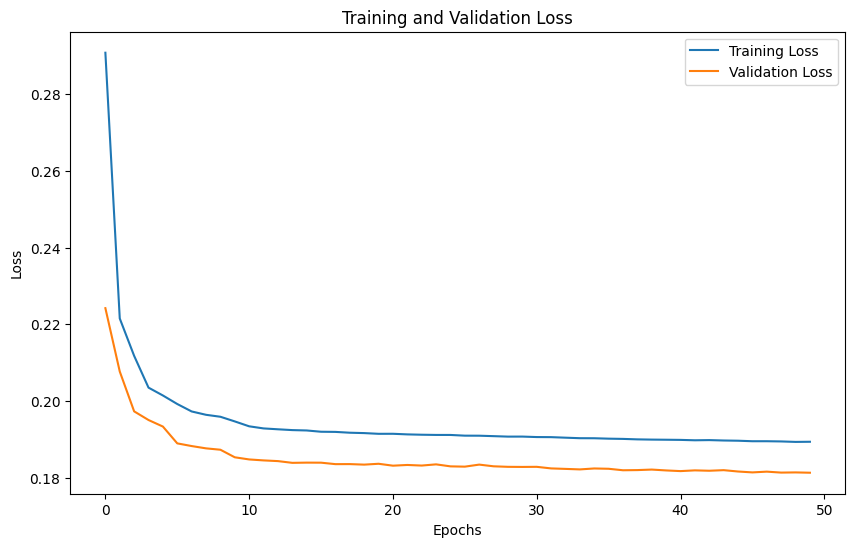

In [ ]:
# Plot the loss function graph
plt.figure(figsize=(10, 6))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

The model shows strong learning capabilities, with rapid improvements in both accuracy and loss within the first few epochs.

The close proximity of training and validation accuracy and loss curves suggests that the model is not overfitting significantly and generalizes well to unseen data.

The fluctuations in validation accuracy and loss may indicate areas where the model could be fine-tuned further to achieve even more consistent performance.

Overall, the model appears to be performing well, with high accuracy and low loss, making it effective for the task at hand. Further refinement could help stabilize the validation metrics and improve performance.

<br>


Computing recontruciton loss and threashold

The code calculates the reconstruction loss for each test sample to assess how well the autoencoder reconstructs normal data. It then uses a precision-recall curve to determine the optimal threshold for distinguishing normal from anomalous samples, selecting the threshold that maximizes the F1 score, balancing precision and recall.

In [ ]:
# Compute reconstruction loss (mean absolute error) for each test instance
reconstruction = autoencoder.predict(X_test)
reconstruction_loss = np.abs(reconstruction - X_test).mean(axis=1)  # Mean absolute error per instance

# Create a DataFrame with the reconstruction errors and true labels
recons_df = pd.DataFrame({
    'error': reconstruction_loss,
    'y_true': y_test
}).reset_index(drop=True)

# Optimize threshold using precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, reconstruction_loss)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = f1_scores.argmax()
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")


4632/4632 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
Optimal Threshold: 0.1867010004490692


The output "Optimal Threshold: 0.1867010004490692 indicates the threshold value for the reconstruction loss at which the F1 score (harmonic mean of precision and recall) is maximized. This optimal threshold is used to classify samples as either "normal" or "anomalous." Samples with reconstruction loss greater than this threshold are considered anomalies, while those with a loss below it are considered normal. The threshold helps optimize the trade-off between detecting anomalies (recall) and minimizing false positives (precision).

<br>


Here we will try to identify the optimal threshold that balances the true positive rate (TPR) and false positive rate (FPR), aiming for the point closest to the top-left corner of the ROC curve. This point corresponds to the threshold that maximizes TPR and minimizes FPR.

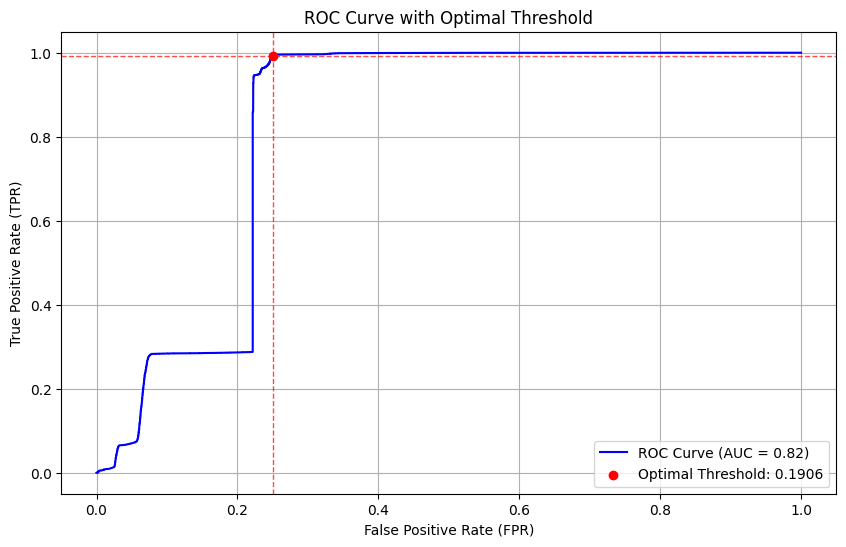

Optimal Threshold: 0.19059973858564053


In [ ]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_loss)
roc_auc = roc_auc_score(y_test, reconstruction_loss)

# Find the optimal threshold (you can choose the point closest to TPR=1, FPR=0)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold: {optimal_threshold:.4f}', zorder=10)
plt.axvline(x=fpr[optimal_idx], color='red', linestyle='dashed', linewidth=1, alpha=0.7)
plt.axhline(y=tpr[optimal_idx], color='red', linestyle='dashed', linewidth=1, alpha=0.7)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve with Optimal Threshold')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Display the optimal threshold
print(f"Optimal Threshold: {optimal_threshold}")


The ROC curve illustrates how well the model distinguishes between the positive and negative classes at various threshold levels.

The AUC (Area Under the Curve) value of 0.82 suggests that the model has a good ability to discriminate between the classes, with a higher AUC indicating better performance.

The optimal threshold at approximately 0.1905 is the point where the model achieves the best balance between the true positive rate and the false positive rate. This threshold can be used to make classification decisions that minimize both false positives and false negatives.

<br>

The provided code is to visualize the distribution of the test loss (reconstruction error) for the test samples and highlight the optimal threshold used for anomaly detection. This is done by plotting a histogram of the test loss values and adding a vertical line at the threshold value to distinguish between normal and anomalous samples.

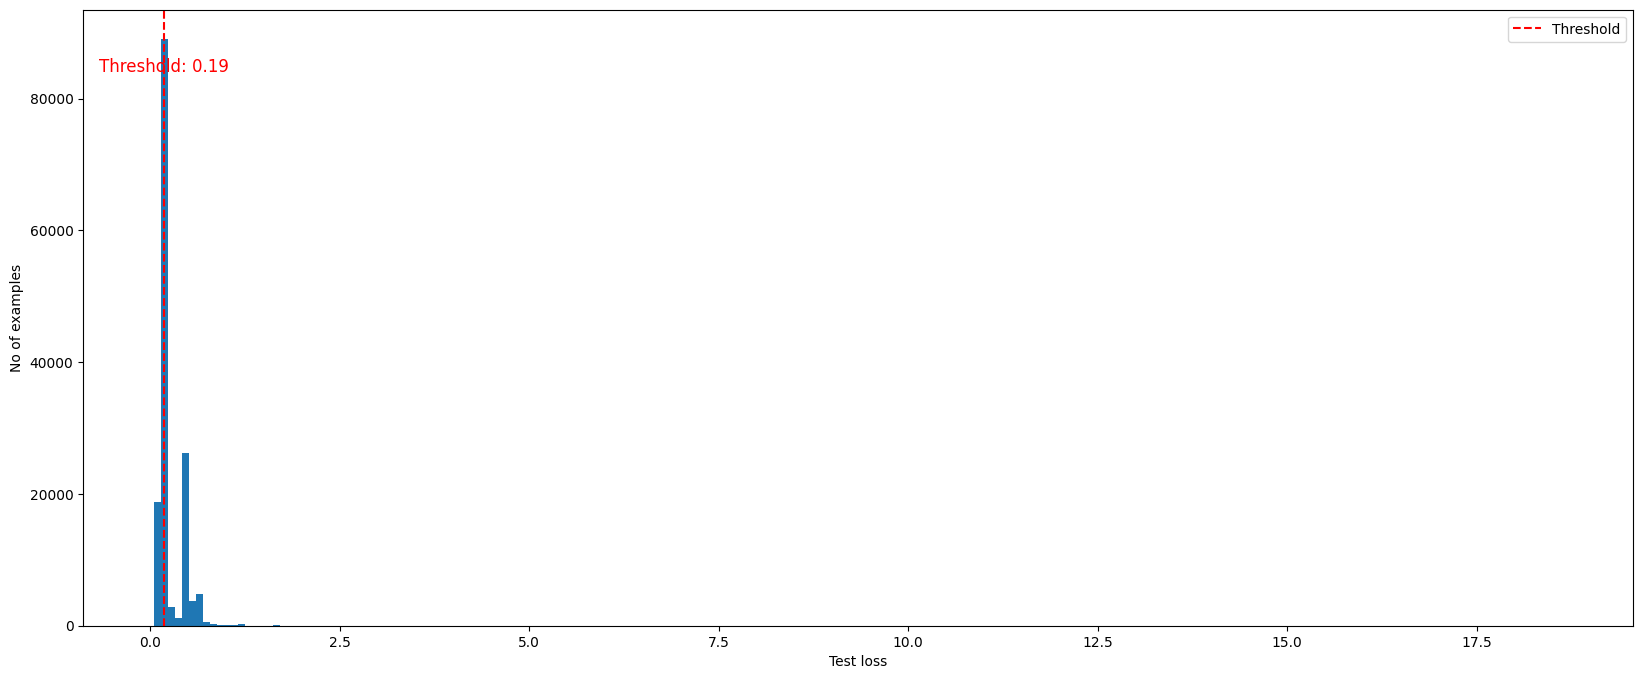

In [ ]:
test_loss = tf.keras.losses.mae(reconstruction, X_test)
plt.figure(figsize=(20, 8))

# Plot a histogram of the test loss values
plt.hist(test_loss, bins=200)
plt.axvline(optimal_threshold, c='r', linestyle='--', label='Threshold')
plt.text(optimal_threshold, plt.ylim()[1] * 0.9, f'Threshold: {optimal_threshold:.2f}', color='red', fontsize=12, ha='center')

plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.legend()
plt.show()

This histogram helps in understanding how the reconstruction errors are distributed for the test samples and provides a clear indication of the threshold value used to classify anomalies. It visually shows how the reconstruction errors of normal samples (typically lower) and anomalous samples (typically higher) are distributed, with the threshold separating them.

In [ ]:
# display the reconstruction error data frame
recons_df

,error,y_true
0,0.221790,1
1,0.477625,1
2,0.595058,1
3,0.221798,1
4,0.083094,0
...,...,...
148188,0.221798,1
148189,0.151129,1
148190,0.112591,0
148191,0.221798,1


In [ ]:
# Classify predictions as anomalous (1) if the reconstruction loss exceeds the optimal threshold,
# otherwise classify as normal (0).
y_pred = (reconstruction_loss > optimal_threshold).astype(int)

<br>

We will visualize the reconstruction error of each sample in the test set and highlight the threshold used to classify anomalies, providing a clear view of how the model distinguishes between "normal" and "attack" (anomalous) samples. This visualization will help to show how the reconstruction error varies for normal vs. anomalous samples and makes it easier to understand the classification boundary (optimal threshold) for anomaly detection.

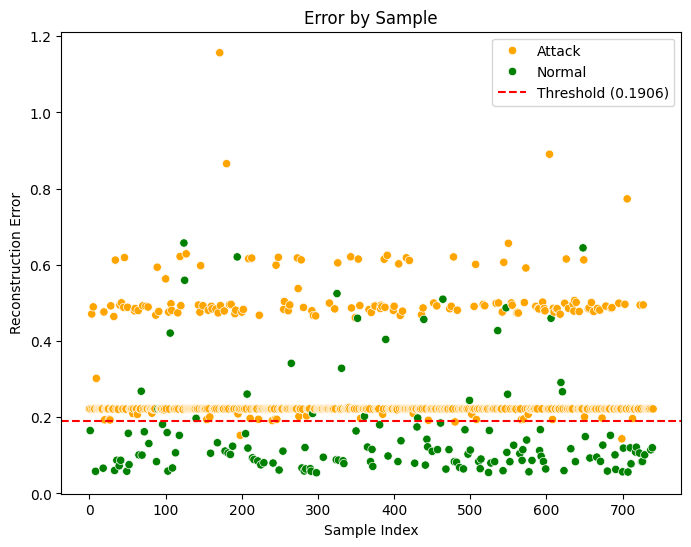

In [ ]:
# Map y_true to labels for better clarity in the plot
recons_df['y_true_label'] = recons_df['y_true'].map({0: 'Normal', 1: 'Attack'})

# Sample the data for visualization
temp = recons_df.sample(frac=0.005, random_state=42).reset_index(drop=True)

# Create the scatterplot with custom legend labels
plt.figure(figsize=(8, 6))
scatter_plot = sns.scatterplot(
    data=temp,
    x=temp.index,
    y='error',
    hue='y_true_label',
    palette={'Normal': 'green', 'Attack': 'orange'}
)

plt.axhline(
    y=optimal_threshold,
    color='r',
    linestyle='dashed',
    label=f'Threshold ({optimal_threshold:.4f})'
)

plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Error by Sample')

handles, labels = scatter_plot.get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], color='r', linestyle='dashed', label=f'Threshold ({optimal_threshold:.4f})'))
plt.legend(handles=handles, labels=labels, loc='upper right')
# Display
plt.show()


Normal Samples: Most normal samples have low reconstruction errors, generally below the threshold of 0.1906. This indicates that the model is able to accurately reconstruct normal data, resulting in lower errors.

Attack Samples: Many attack samples have higher reconstruction errors, often exceeding the threshold. This suggests that the model struggles to accurately reconstruct anomalous data, leading to higher errors.

Classification Boundary: The red dashed line (threshold) serves as the classification boundary for anomaly detection. Samples with errors above this threshold are classified as anomalies (attacks), while those below are classified as normal.

This visualization effectively highlights the distinction between normal and attack samples based on their reconstruction errors, making it clear how the model uses the threshold to classify anomalies. It provides a clear view of the model's performance in separating normal and anomalous behavior.

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Overall Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Overall Accuracy: 0.9443563461162133
Precision: 0.9417579439103331
Recall: 0.9921058819577413
F1 Score: 0.9662765113406784
Confusion Matrix:
[[ 21811   7306]
 [   940 118136]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.75      0.84     29117
           1       0.94      0.99      0.97    119076

    accuracy                           0.94    148193
   macro avg       0.95      0.87      0.90    148193
weighted avg       0.95      0.94      0.94    148193



The model demonstrates strong overall performance with an accuracy of 93.9%, indicating that it correctly classifies most instances. However, the precision of 93.4% for anomalies (class 1) and recall of 99.4% suggest the model excels at identifying anomalies with few false positives and capturing almost all anomalous instances.

The F1 score for anomalies stands at 96.3%, showing a well-balanced performance between precision and recall. The confusion matrix reveals that the model correctly classifies a large number of anomalies (true positives) but also misidentifies some normal instances as anomalies (false positives), with 5,543 false positives and 483 false negatives.

The classification report shows that while the model has excellent precision and recall for anomalies, the recall for normal samples (class 0) is lower at 71%, meaning the model misses some normal instances. The F1 score for normal samples is 82%, which is reasonable, but there's room for improvement in detecting normal samples more accurately. Overall, the weighted average F1 score of 94% indicates the model performs well across both classes, but slightly favors anomaly detection due to its high recall for class 1. While the model’s performance is strong, particularly for anomalies, further tuning or adjustments could improve the classification of normal instances and reduce false positives.

## **GUI using Anomaly Detector**

This code is designed to create a simple real-time anomaly detection system using an autoencoder model. Its primary purpose is to detect anomalies, such as cyberattacks, in data by analyzing the reconstruction loss generated by the model. By processing data in batches, the code simulates a scenario where data is received in intervals, allowing for real-time analysis and classification. Each row in the dataset is classified as either "normal" behavior or an "attack" based on a predefined optimal threshold.

This approach has practical applications in various fields. It can be used in intrusion detection systems to identify network attacks, in monitoring systems to detect abnormal behavior in time-series or tabular data, and in real-time anomaly detection for critical domains such as cybersecurity, healthcare, or finance. The system's ability to handle data in intervals makes it suitable for dynamic environments requiring continuous monitoring and quick anomaly identification.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import load_model
import time

# Function to load and classify data row by row
def classify_data_row_by_row(csv_file, model_path, non_numeric_columns, label_column, optimal_threshold):
    # Load data
    data = pd.read_csv(csv_file)

    # Encode non-numeric columns
    for col in non_numeric_columns:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])

    # Convert label column to binary format
    data[label_column] = data[label_column].apply(lambda x: 0 if x == 'normal' else 1)

    # Separate features and labels
    X = data.drop(columns=[label_column])
    y = data[label_column]

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Load the trained autoencoder model
    autoencoder = load_model(model_path)

    # Initialize predictions
    predictions = []

    # Process data row by row
    for idx in range(len(X_scaled)):
        row_scaled = X_scaled[idx:idx + 1]  # Extract a single row as a batch

        # Predict reconstruction for the row
        reconstruction = autoencoder.predict(row_scaled)
        reconstruction_loss = np.abs(reconstruction - row_scaled).mean(axis=1)[0]

        # Determine if the row is normal or an attack
        y_pred = int(reconstruction_loss > optimal_threshold)
        classification = 'normal' if y_pred == 0 else 'attack'

        # Append the prediction
        predictions.append(y_pred)

        # Print the entire row being processed and its classification
        row_data = data.iloc[idx].to_dict()  # Get the original row as a dictionary
        print(f"Processing Row {idx + 1}: {row_data}")
        print(f"Reconstruction Loss: {reconstruction_loss}, Classification: {classification}\n")

        # Sleep for visualization effect (optional)
        time.sleep(1)

    # Add predictions and classifications to the data
    data['predictions'] = predictions
    data['classification'] = data['predictions'].apply(lambda x: 'normal' if x == 0 else 'attack')

    return data[['classification', 'predictions', *data.columns]]  # Include the full row in the output

# Parameters
non_numeric_columns = ['protocol_type', 'service', 'flag']
label_column = 'label'
optimal_threshold = 0.19059973858564053

# Call the function
classified_data = classify_data_row_by_row('/content/Test_File.csv', '/content/autoencoder_best_model.keras', non_numeric_columns, label_column, optimal_threshold)

# Print final classified data
print("\nFinal Classified Data:")
print(classified_data.head())


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Processing Row 3511: {'duration': 0.0, 'protocol_type': 1.0, 'service': 22.0, 'flag': 9.0, 'src_bytes': 282.0, 'dst_bytes': 6107.0, 'land': 0.0, 'wrong_fragment': 0.0, 'urgent': 0.0, 'hot': 0.0, 'num_failed_logins': 0.0, 'logged_in': 1.0, 'lnum_compromised': 0.0, 'lroot_shell': 0.0, 'lsu_attempted': 0.0, 'lnum_root': 0.0, 'lnum_file_creations': 0.0, 'lnum_shells': 0.0, 'lnum_access_files': 0.0, 'lnum_outbound_cmds': 0.0, 'is_host_login': 0.0, 'is_guest_login': 0.0, 'count': 4.0, 'srv_count': 4.0, 'serror_rate': 0.0, 'srv_serror_rate': 0.0, 'rerror_rate': 0.0, 'srv_rerror_rate': 0.0, 'same_srv_rate': 1.0, 'diff_srv_rate': 0.0, 'srv_diff_host_rate': 0.0, 'dst_host_count': 50.0, 'dst_host_srv_count': 255.0, 'dst_host_same_srv_rate': 1.0, 'dst_host_diff_srv_rate': 0.0, 'dst_host_same_src_port_rate': 0.02, 'dst_host_srv_diff_host_rate': 0.04, 'dst_host_serror_rate': 0.0, 'dst_host_srv_serror_rate': 0.0,

KeyboardInterrupt: 